<center><h1>DSCI-552 HOMEWORK 3</h1><center>
<br>
<center><font size="4">Time Series Classification</font></center>
<center><font size="3"><strong>Mason(Mohan) Xing</font></center>
<center><font size="3"><strong>USCID:	6880083372</font></center>

In [1]:
# import dependencies
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

import os
import re
import urllib
import zipfile
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import collections
import math
from sklearn import preprocessing
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
import sklearn.linear_model as lm
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, roc_curve, auc, plot_confusion_matrix, accuracy_score,classification_report
import scipy.stats as stat
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
import statsmodels.api as sm 

# check the environment
print (os.environ['CONDA_DEFAULT_ENV'])

dsci552


# 1. Time Series Classification
## (a) Download the AReM data 

https://archive.ics.uci.edu/ml/machine-learning-databases/00366/

In [2]:
# # download original dataset
# url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00366/AReM.zip"
# datafile = "../data/AReM.zip"
# urllib.request.urlretrieve(url, datafile)

# with zipfile.ZipFile(datafile, 'r') as zip_ref:
#     zip_ref.extractall("../data/AReM")
#     zip_ref.close()

# os.remove(datafile)

In [3]:
# check all files
# assign path
rootdir = "../data/AReM"
error_file = []
# walk thru all files and save the path for different sets
for root, dirs, files in os.walk(rootdir):
    for name in files:
        if name.endswith(".csv"):
            try:
                df = pd.read_csv(os.path.join(root, name), skiprows=4)
                obj=df.isnull().sum()
                d = obj.to_dict()
                null = sum(d.values())
                if null/df.size*100 > 50: #define whatever a number you thought is wrong
                    print(os.path.join(root, name))
                    error_file.append(os.path.join(root, name))
            except:
                print(os.path.join(root, name))
                error_file.append(os.path.join(root, name))

../data/AReM\bending2\dataset4.csv
../data/AReM\cycling\dataset14.csv
../data/AReM\cycling\dataset9.csv


The above result shows the dataframe with problem, then we test these file one by one

In [4]:
csv_file = error_file[0]
print(error_file[0])
df_test = pd.read_csv(csv_file, skiprows=4)
df_test.head()

../data/AReM\bending2\dataset4.csv


,# Columns: time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23
0,0 32.50 0.50 0.00 0.00 19.00 1.00,NaN,NaN,NaN,NaN,NaN,NaN
1,250 32.50 0.50 0.00 0.00 18.50 0.50,NaN,NaN,NaN,NaN,NaN,NaN
2,500 32.75 0.43 1.00 0.00 18.00 0.00,NaN,NaN,NaN,NaN,NaN,NaN
3,750 32.50 0.50 0.00 0.00 17.50 0.50,NaN,NaN,NaN,NaN,NaN,NaN
4,1000 32.50 0.50 7.50 0.50 17.50 0.87,NaN,NaN,NaN,NaN,NaN,NaN


* The above result indicates this csv file delimiter is space

In [5]:
csv_file = error_file[1]
print(csv_file)
df_test = pd.read_csv(csv_file, skiprows=4, error_bad_lines=False)

../data/AReM\cycling\dataset14.csv


b'Skipping line 485: expected 7 fields, saw 8\n'


In [6]:
csv_file = error_file[2]
print(csv_file)
df_test = pd.read_csv(csv_file, skiprows=4, error_bad_lines=False)

../data/AReM\cycling\dataset9.csv


b'Skipping line 485: expected 7 fields, saw 8\n'


* The above result indicates it is a column reading error then we set certain columns when using pandas

In [7]:
# Define function read all csv files and return a df
def read_csv(file):
    if file == error_file[0]:
        df = pd.read_csv(error_file[0], sep="\s+", skiprows=5, header=None, usecols=[1,2,3,4,5,6])
    else:
        df = pd.read_csv(file, skiprows=4, usecols=[1,2,3,4,5,6])
    return df

## (b) Keep datasets 1 and 2 in folders bending1 and bending 2, as well as datasets 1,2, and 3 in other folders as test data and other datasets as train data.

In [8]:
train_files = []
test_files = []
all_files = []
for root, dirs, files in os.walk(rootdir):
    for name in files:
        path = os.path.join(root, name)
        if name.endswith(".csv"):
            all_files.append(path)
            if "bending" in path:
                if (name == "dataset1.csv" or name == "dataset2.csv"):
                    test_files.append(path)
                else:
                    train_files.append(path)
            else:
                if (name == "dataset1.csv" or name == "dataset2.csv" or name == "dataset3.csv"):
                    test_files.append(path)
                else:
                    train_files.append(path)

In [9]:
print("Number of all files: ", len(all_files) )
print("Number of test files: ", len(test_files) )
print("Number of train files: ", len(train_files) )

Number of all files:  88
Number of test files:  19
Number of train files:  69


In [10]:
# define a function to covert file into a dataframe then append these dfs into a list
def dfs_list(files):
    df_list = []
    for file in files:
        df = read_csv(file)
        df_list.append(df)
    return df_list

In [11]:
# define dataframe list to store all/train/test files
all_dfs = dfs_list(all_files)
train_dfs = dfs_list(train_files)
test_dfs = dfs_list(test_files)

## (c) Feature Extraction
### Classification of time series usually needs extracting features from them. In this problem, we focus on time-domain features.
### c(i) Research what types of time-domain features are usually used in time series classification and list them (examples are minimum, maximum, mean, etc).

ref: https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-020-1063-x </br>
* The central tendency reflects the representative value of the general level of the data or the central value, including statistics such as the mean, median, mode and quantile. 
* The dispersion tendency of the distribution reflects trends describing how far the data are from the central value, including statistics such as maximum, minimum, standard deviation, coefficient of variation, range and interquartile range. 


### c(ii). Extract the time-domain features minimum, maximum, mean, median, standard deviation, first quartile, and third quartile for all of the 6 time series in each instance. You are free to normalize/standardize features or use them directly.

In [12]:
# define feature extraction function for each file
def feature_extract(df):
    
    df1 = df.describe().T
    df2 = df1[['min', 'max', 'mean', '50%', 'std', '25%', '75%']] # rearrange the column order
    df3 = df2.stack().to_frame().T # Transpose the df to meet the requirement
    
    return df3

In [13]:
# define feature row rename function
def rename_feature(df):
    
    header = ['min', 'max', 'mean', 'median', 'standard deviation', '1st quartile', '3rd quartile']
    header_new = [[x+str(i) for x in header] for i in range(1,int(len(df.columns)/7)+1)]
    header_new2 = [item for elem in header_new for item in elem]
    df1 = df.set_axis(header_new2, axis=1, inplace=False)
    
    return df1

In [14]:
# define set extraction funtion
def dataset_feature(dfs, index=[], scale='raw'):
    
    append_data = []
    for df in dfs:
        if scale == 'norm':
            df_norm = df.copy()
            scaler = MinMaxScaler()
            df_norm[df_norm.columns] = scaler.fit_transform(df_norm[df_norm.columns])
            data = feature_extract(df_norm)
        elif scale == 'std':
            df_std = df.copy()
            scaler = StandardScaler()
            df_std[df_std.columns] = scaler.fit_transform(df_std[df_std.columns])
            data = feature_extract(df_std)
        else:
            data = feature_extract(df) 
        data1 = rename_feature(data)
        append_data.append(data1)
        
    df_feature = pd.concat(append_data)
    
    if index != []:
        df_feature.index = index
        df_feature.index.name = 'Instance'
        return df_feature
    else:
        return df_feature

In [15]:
# index of all instances
all_files_index = [all_files.index(x)+1 for x in all_files]
train_files_index = [all_files.index(x)+1 for x in train_files]
test_files_index = [all_files.index(x)+1 for x in test_files]

### Raw Features

In [16]:
# extract feature for all files and show complete dataframe example
df_all = dataset_feature(all_dfs, all_files_index)
print("All set feature df shape is: ", df_all.shape)

df_train = dataset_feature(train_dfs, train_files_index)
print("Train set feature df shape is: ", df_train.shape)

df_test = dataset_feature(test_dfs, test_files_index)
print("Test set feature df shape is: ", df_test.shape)
df_all.head()

All set feature df shape is:  (88, 42)
Train set feature df shape is:  (69, 42)
Test set feature df shape is:  (19, 42)


,min1,max1,mean1,median1,standard deviation1,1st quartile1,3rd quartile1,min2,max2,mean2,...,standard deviation5,1st quartile5,3rd quartile5,min6,max6,mean6,median6,standard deviation6,1st quartile6,3rd quartile6
Instance,,,,,,,,,,,,,,,,,,,,,
1,37.25,45.00,40.624792,40.50,1.476967,39.25,42.00,0.0,1.30,0.358604,...,2.188449,33.0000,36.00,0.0,1.92,0.570583,0.43,0.582915,0.0,1.30
2,38.00,45.67,42.812812,42.50,1.435550,42.00,43.67,0.0,1.22,0.372438,...,1.995255,32.0000,34.50,0.0,3.11,0.571083,0.43,0.601010,0.0,1.30
3,35.00,47.40,43.954500,44.33,1.558835,43.00,45.00,0.0,1.70,0.426250,...,1.999604,35.3625,36.50,0.0,1.79,0.493292,0.43,0.513506,0.0,0.94
4,33.00,47.75,42.179813,43.50,3.670666,39.15,45.00,0.0,3.00,0.696042,...,3.849448,30.4575,36.33,0.0,2.18,0.613521,0.50,0.524317,0.0,1.00
5,33.00,45.75,41.678063,41.75,2.243490,41.33,42.75,0.0,2.83,0.535979,...,2.411026,28.4575,31.25,0.0,1.79,0.383292,0.43,0.389164,0.0,0.50


### Normalized Features

In [17]:
# extract feature for all files and show complete dataframe example
# df_all_norm = dataset_feature(all_dfs, all_files_index, scale='norm')
# print("All set feature df shape is: ", df_all_norm.shape)

# df_train_norm = dataset_feature(train_dfs, train_files_index, scale='norm')
# print("Train set feature df shape is: ", df_train_norm.shape)

# df_test_norm = dataset_feature(test_dfs, test_files_index, scale='norm')
# print("Test set feature df shape is: ", df_test_norm.shape)
# df_all_norm.head()

### Standardize Features

In [18]:
# # extract feature for all files and show complete dataframe example
# df_all_std = dataset_feature(all_dfs, all_files_index, scale='std')
# print("All set feature df shape is: ", df_all_norm.shape)

# df_train_std = dataset_feature(train_dfs, train_files_index, scale='std')
# print("Train set feature df shape is: ", df_train_norm.shape)

# df_test_std = dataset_feature(test_dfs, test_files_index, scale='std')
# print("Test set feature df shape is: ", df_test_norm.shape)
# df_all_std.head()

### c(iii). Estimate the standard deviation of each of the time-domain features you extracted from the data. Then, use Python's bootstrapped or any other method to build a 90% bootsrap confidence interval for the standard deviation of each feature.

In [19]:
def bootstrap(df, alpha):
    values = []
    interval = []
    errorwidth = []
    for c in df.columns:
        result = bs.bootstrap(df[c].values, stat_func=bs_stats.std, alpha=alpha, num_iterations=10000, 
                              iteration_batch_size=10,is_pivotal=False)
        values.append(result.value)
        errorwidth.append(result.error_width())
        interval.append((result.lower_bound, result.upper_bound))
    return values, interval, errorwidth

In [20]:
def result_table(df, alpha):
    df_new = pd.DataFrame(df.describe().T['std'])
    df_new['bootstrap std'] = bootstrap(df, alpha)[0]
    df_new['90 percent interval'] = bootstrap(df, alpha)[1]
    df_new['error_width'] = bootstrap(df, alpha)[2]
    return df_new

### Raw Features

In [21]:
alpha = 0.1
df_c_all = result_table(df_all, alpha)
df_c_all

,std,bootstrap std,90 percent interval,error_width
min1,9.569975,9.405393,"(8.224097805337925, 10.730940464837495)",2.492033
max1,4.394362,4.310435,"(3.321889315986534, 5.253100032388466)",1.926283
mean1,5.335718,5.261492,"(4.683691207317501, 5.842413588993038)",1.182530
median1,5.440054,5.361605,"(4.765969273196628, 5.960280534267209)",1.187366
standard deviation1,1.772153,1.747147,"(1.55938616618299, 1.941716819290038)",0.373867
1st quartile1,6.153590,6.074262,"(5.528369139361328, 6.6125662741017965)",1.062373
3rd quartile1,5.138925,5.059644,"(4.311552988836763, 5.807528108312512)",1.498224
min2,0.000000,0.000000,"(0.0, 0.0)",0.000000
max2,5.062729,5.005870,"(4.595652108702622, 5.372891893491016)",0.780025
mean2,1.574164,1.561181,"(1.3878787780123385, 1.6966187124509124)",0.307084


### Normalized Features

In [22]:
# df_c_all_norm = result_table(df_all_norm, alpha)
# df_c_all_norm

### Standardize Features

In [23]:
# df_c_all_std = result_table(df_all_std, alpha)
# df_c_all_std

### c(iv). Use your judgement to select the three most important time-domain features (one option may be min, mean, and max).

In [24]:
# define a function to add the subdir column to each instance
def file_column(df, files):

    temp_list = []
    for f in files:
        subdir1 = f.lstrip("../data/AReM")
        subdir2 = subdir1.split('data')[0]
        subdir3 = re.findall(r'\w+', subdir2)
        temp_list.append(subdir3[0])
        
    return temp_list

In [25]:
# define function to add label 
def add_label(df, files):
    
    temp_list = file_column(df, files) # call add_file_column function
    df['subdir'] = temp_list
    df['label']=['bending' in x for x in df['subdir']]
    df1 = df.drop(columns=['subdir'])
    df2 = pd.get_dummies(df1, columns=['label'])
    df3 = df2.drop(columns=['label_False'])
    df4 = df3.rename(columns={"label_True": "label"})
    
    return df4

In [26]:
def make_plot(df):
    fig, axes = plt.subplots(7, 6, figsize=(16,16))

    i=0
    j=0
    # axes = axes.ravel()
    for c in df.columns[0:42]:
        sns.histplot(data=df.loc[df.label==1], 
                    x=c,fill=True, color="blue",element="step", label='Bending', ax=axes[i,j])
        sns.histplot(data=df.loc[df.label==0], 
                    x=c, fill=True,color="orange", element="step",label='Not Bending',ax=axes[i,j])
        axes[i,j].legend(loc=9)
        i+=1
        if i == 7:
            i=0
            j+=1
        if j == 6:
            i+=1
            j=0
    plt.tight_layout()
    plt.show()

In [27]:
# add label to raw data
df_all_label = add_label(df_all, all_files)
df_train_label = add_label(df_train, train_files)
df_test_label = add_label(df_test, test_files)

# # add label to normalized data
# df_all_norm_label = add_label(df_all_norm, all_files)
# df_train_norm_label = add_label(df_train_norm, train_files)
# df_test_norm_label = add_label(df_test_norm, test_files)

# # add label to standardize data
# df_all_std_label = add_label(df_all_std, all_files)
# df_train_std_label = add_label(df_train_std, train_files)
# df_test_std_label = add_label(df_test_std, test_files)

### Raw Features

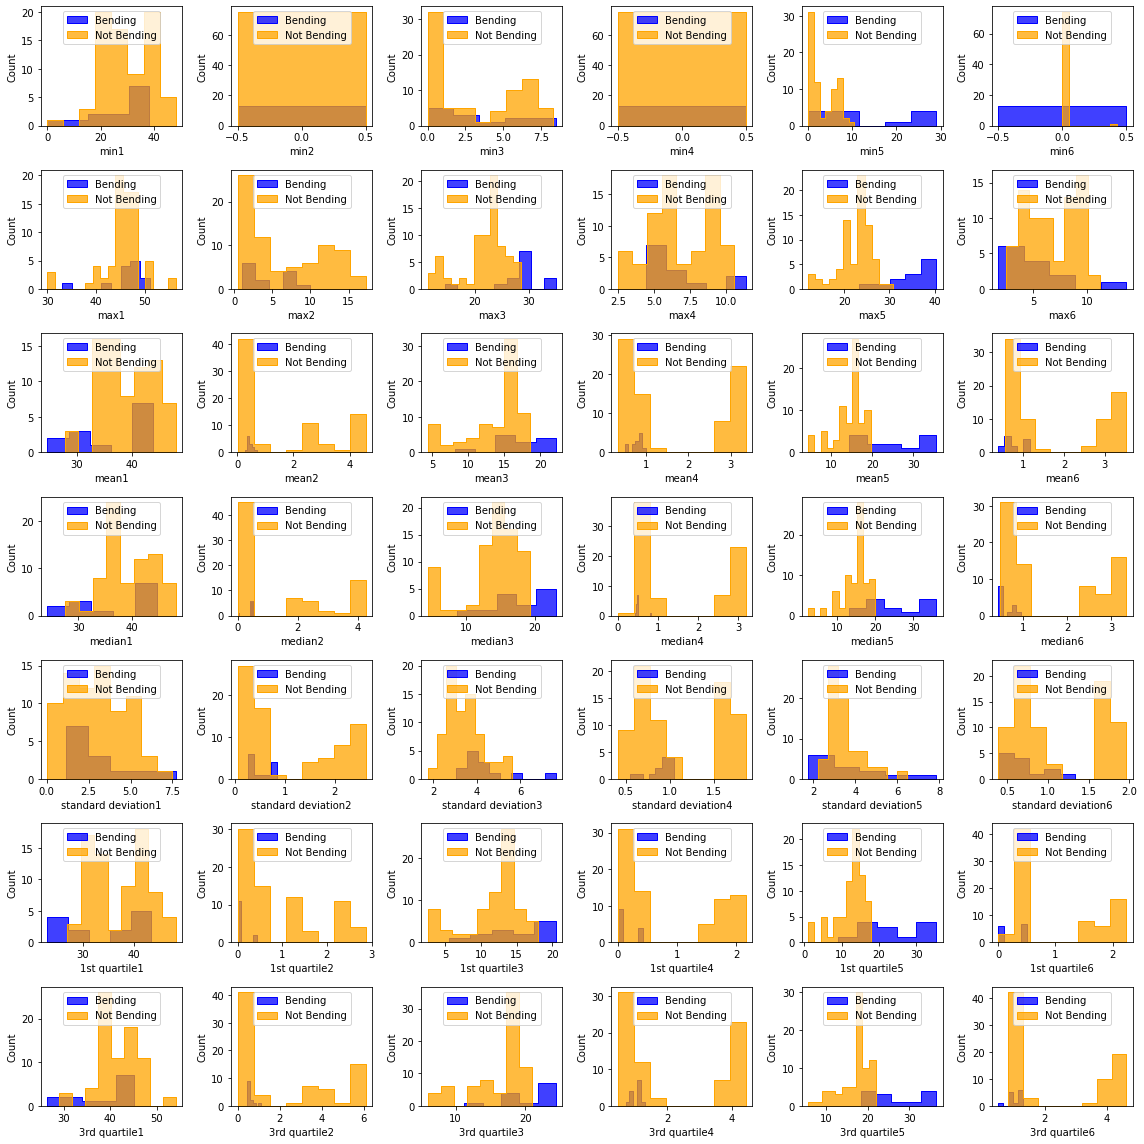

In [28]:
make_plot(df_all_label)

### Normalized Features

In [29]:
# make_plot(df_all_norm_label)

### Standardize Features

In [30]:
## round of decimals otherwise it will never plot
# df_all_std_label = df_all_std_label.round(decimals=8)
# make_plot(df_all_std_label)

<strong>Answer</strong>
* Some of the 'min', 'max' and '3rd quartile' have the least overlaps in the distribution meanwhile they have the relatively large bootstrap confidence interval so I think these three can be good candidates for the below problems

## (d) Binary Classification Using Logistic Regression
### d(i). Assume that you want to use the training set to classify bending from other activities, i.e. you have a binary classification problem. Depict scatter plots of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of each instance, and use color to distinguish bending vs. other activities.

In [31]:
def scatterplot(df, select_feature, select_series):
    select_f = [x+str(i) for i in select_series for x in select_feature]
    select_f.append('label')
    g = sns.pairplot(df[select_f], hue='label')
    plt.show()

### Raw Features

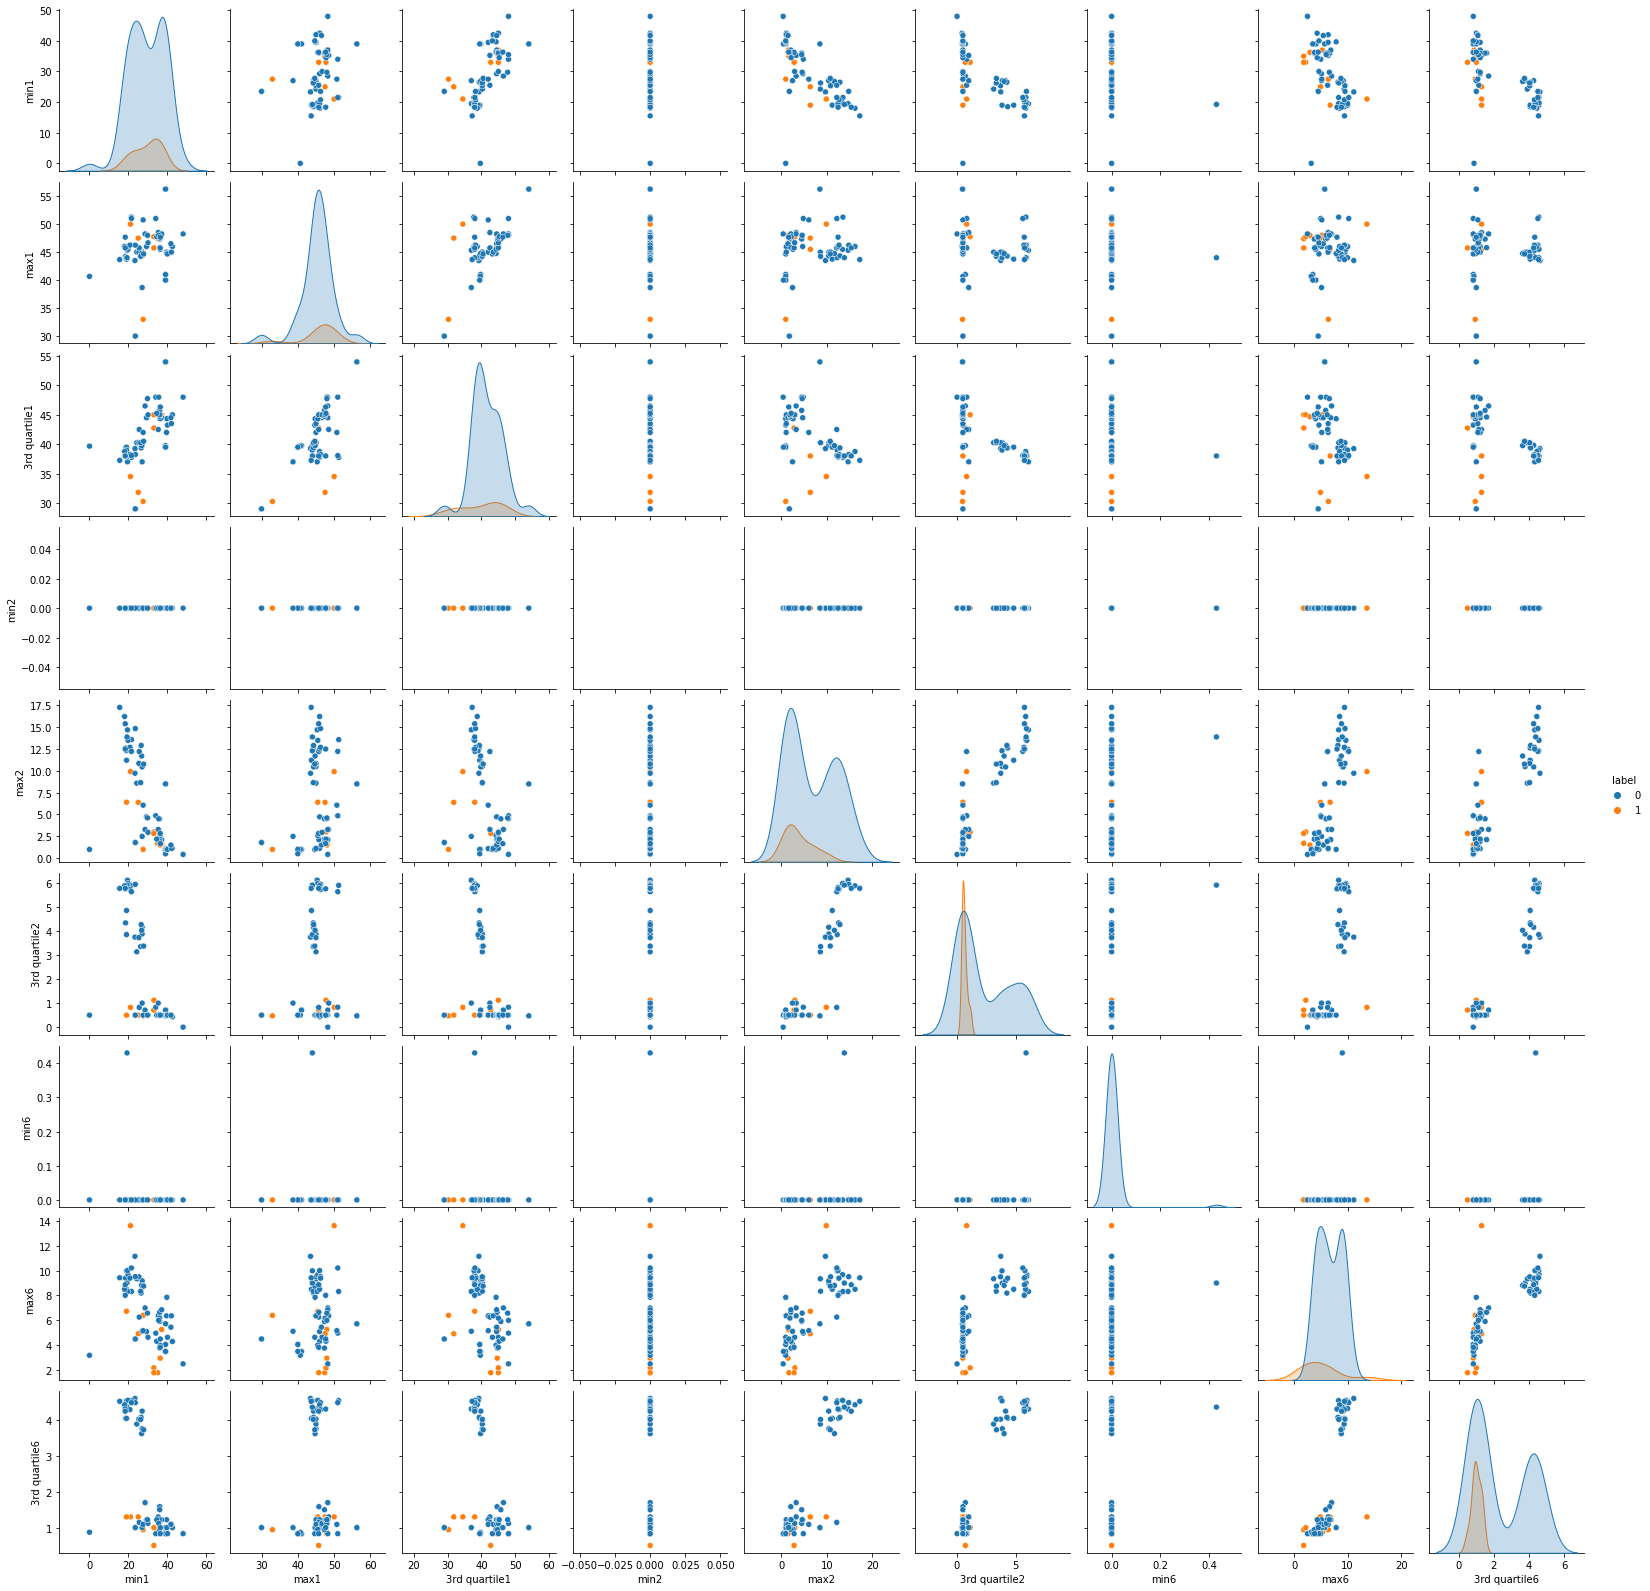

In [32]:
# define select features
select_features = ['min', 'max', '3rd quartile'] # may change later

select_series = [1,2,6]
scatterplot(df_train_label, select_features, select_series)

### Normalized Features

In [33]:
# scatterplot(df_train_norm_label, select_feature, select_series)

### Standardize Features

In [34]:
# scatterplot(df_train_std_label, select_feature, select_series)

* The first observation is bending samples have less data than non-bending samples.
* Featuers have no strong correlations with other feature for example the min vs others.
* bending and non-bending samples may well separated in classification process.

### d(ii). Break each time series in your training set into two (approximately) equal length time series. Now instead of 6 time series for each of the training instances, you have 12 time series for each training instance. Repeat the experiment in 1(d)i, i.e depict scatter plots of the features extracted from both parts of the time series 1,2, and 12. Do you see any considerable difference in the results with those of 1(d)i?

In [35]:
# check how many rows in each data file
temp_list = []
for df in all_dfs:
    temp_list.append(len(df))
    occurrences = collections.Counter(temp_list)
    num_rows = max(occurrences, key=occurrences.get)
print(occurrences)
print(num_rows)

Counter({480: 87, 479: 1})
480


In [36]:
# define a function to split the data and calculate the time series features then combine
def splitCombine(df, l, scale):
   
    if scale == 'norm':
        df_norm = df.copy()
        scaler = MinMaxScaler()
        df_norm[df_norm.columns] = scaler.fit_transform(df_norm[df_norm.columns])
        data = df_norm
    elif scale == 'std':
        df_std = df.copy()
        scaler = StandardScaler()
        df_std[df_std.columns] = scaler.fit_transform(df_std[df_std.columns])
        data = df_std
    else:
        data = df
        
    n = math.ceil(data.shape[0]/l) # define chunk size
    list_df = [data[i:i+n] for i in range(0,data.shape[0],n)] # create df chunk list
    
    part_list = []
    for part in list_df:
        df_part = feature_extract(part).reset_index(drop='index') #call feature_extract function
        part_list.append(df_part)
    df_combine = pd.concat(part_list, axis=1, ignore_index=True)
    df_combine2= rename_feature(df_combine)
    
    return df_combine2

In [37]:
# concat all instance together as a dataframe
def dataset_featureL(dfs, l, select_features, index=[], scale='raw'):
    
    append_data = []
    for df in dfs:
        df_temp = splitCombine(df, l, scale) # call splitCombine() function
        append_data.append(df_temp)
    df_feature = pd.concat(append_data, ignore_index=True)
    
    if index!=[]:
        df_feature.index = index
        df_feature.index.name = 'Instance'
    
    if select_features != []:
        columns = df_feature.columns
        feature_new = [i for i in columns if any(i for j in select_features if str(j) in i)]
        df_feature_select = df_feature[feature_new]
        return df_feature_select
    else:
        return df_feature

In [38]:
# split features
l = 2
df_train_T12 = dataset_featureL(train_dfs, l, select_features, train_files_index, scale='raw')
print("Raw Train set feature df shape is: ", df_train_T12.shape)

df_train_norm_T12 = dataset_featureL(train_dfs, l, select_features,train_files_index, scale='norm')
print("Normalize Train set feature df shape is: ", df_train_norm_T12.shape)

df_train_std_T12 = dataset_featureL(train_dfs, l, select_features, train_files_index, scale='std')
print("Standardize Train set feature df shape is: ", df_train_std_T12.shape)

df_train_T12.head()

Raw Train set feature df shape is:  (69, 36)
Normalize Train set feature df shape is:  (69, 36)
Standardize Train set feature df shape is:  (69, 36)


,min1,max1,3rd quartile1,min2,max2,3rd quartile2,min3,max3,3rd quartile3,min4,...,3rd quartile9,min10,max10,3rd quartile10,min11,max11,3rd quartile11,min12,max12,3rd quartile12
Instance,,,,,,,,,,,,,,,,,,,,,
3,36.50,46.50,45.00,0.0,1.50,0.50,14.25,29.25,24.0000,0.0,...,24.00,0.0,4.44,0.7100,29.00,38.25,36.2500,0.0,1.50,0.71
4,33.75,47.75,45.25,0.0,3.00,1.00,11.00,30.00,24.8125,0.0,...,24.00,0.0,5.15,1.4800,20.00,38.50,33.7500,0.0,2.18,0.87
5,33.00,45.75,44.25,0.0,2.83,0.83,3.00,28.25,24.0000,0.0,...,20.75,0.0,2.35,0.8300,26.00,36.00,30.5625,0.0,1.50,0.50
6,39.00,48.00,45.00,0.0,1.30,0.50,6.25,27.00,20.0000,0.0,...,15.00,0.0,5.21,0.8225,8.00,26.00,23.7500,0.0,4.06,0.71
7,36.67,45.00,44.50,0.0,1.30,0.50,4.00,26.33,18.0000,0.0,...,18.00,0.0,3.56,0.8875,13.75,26.00,23.5000,0.0,2.96,0.83


In [39]:
# add label to the train dataset
df_train_T12_label = add_label(df_train_T12, train_files)
df_train_T12_norm_label = add_label(df_train_norm_T12, train_files)
df_train_T12_std_label = add_label(df_train_std_T12, train_files)

### Raw Features

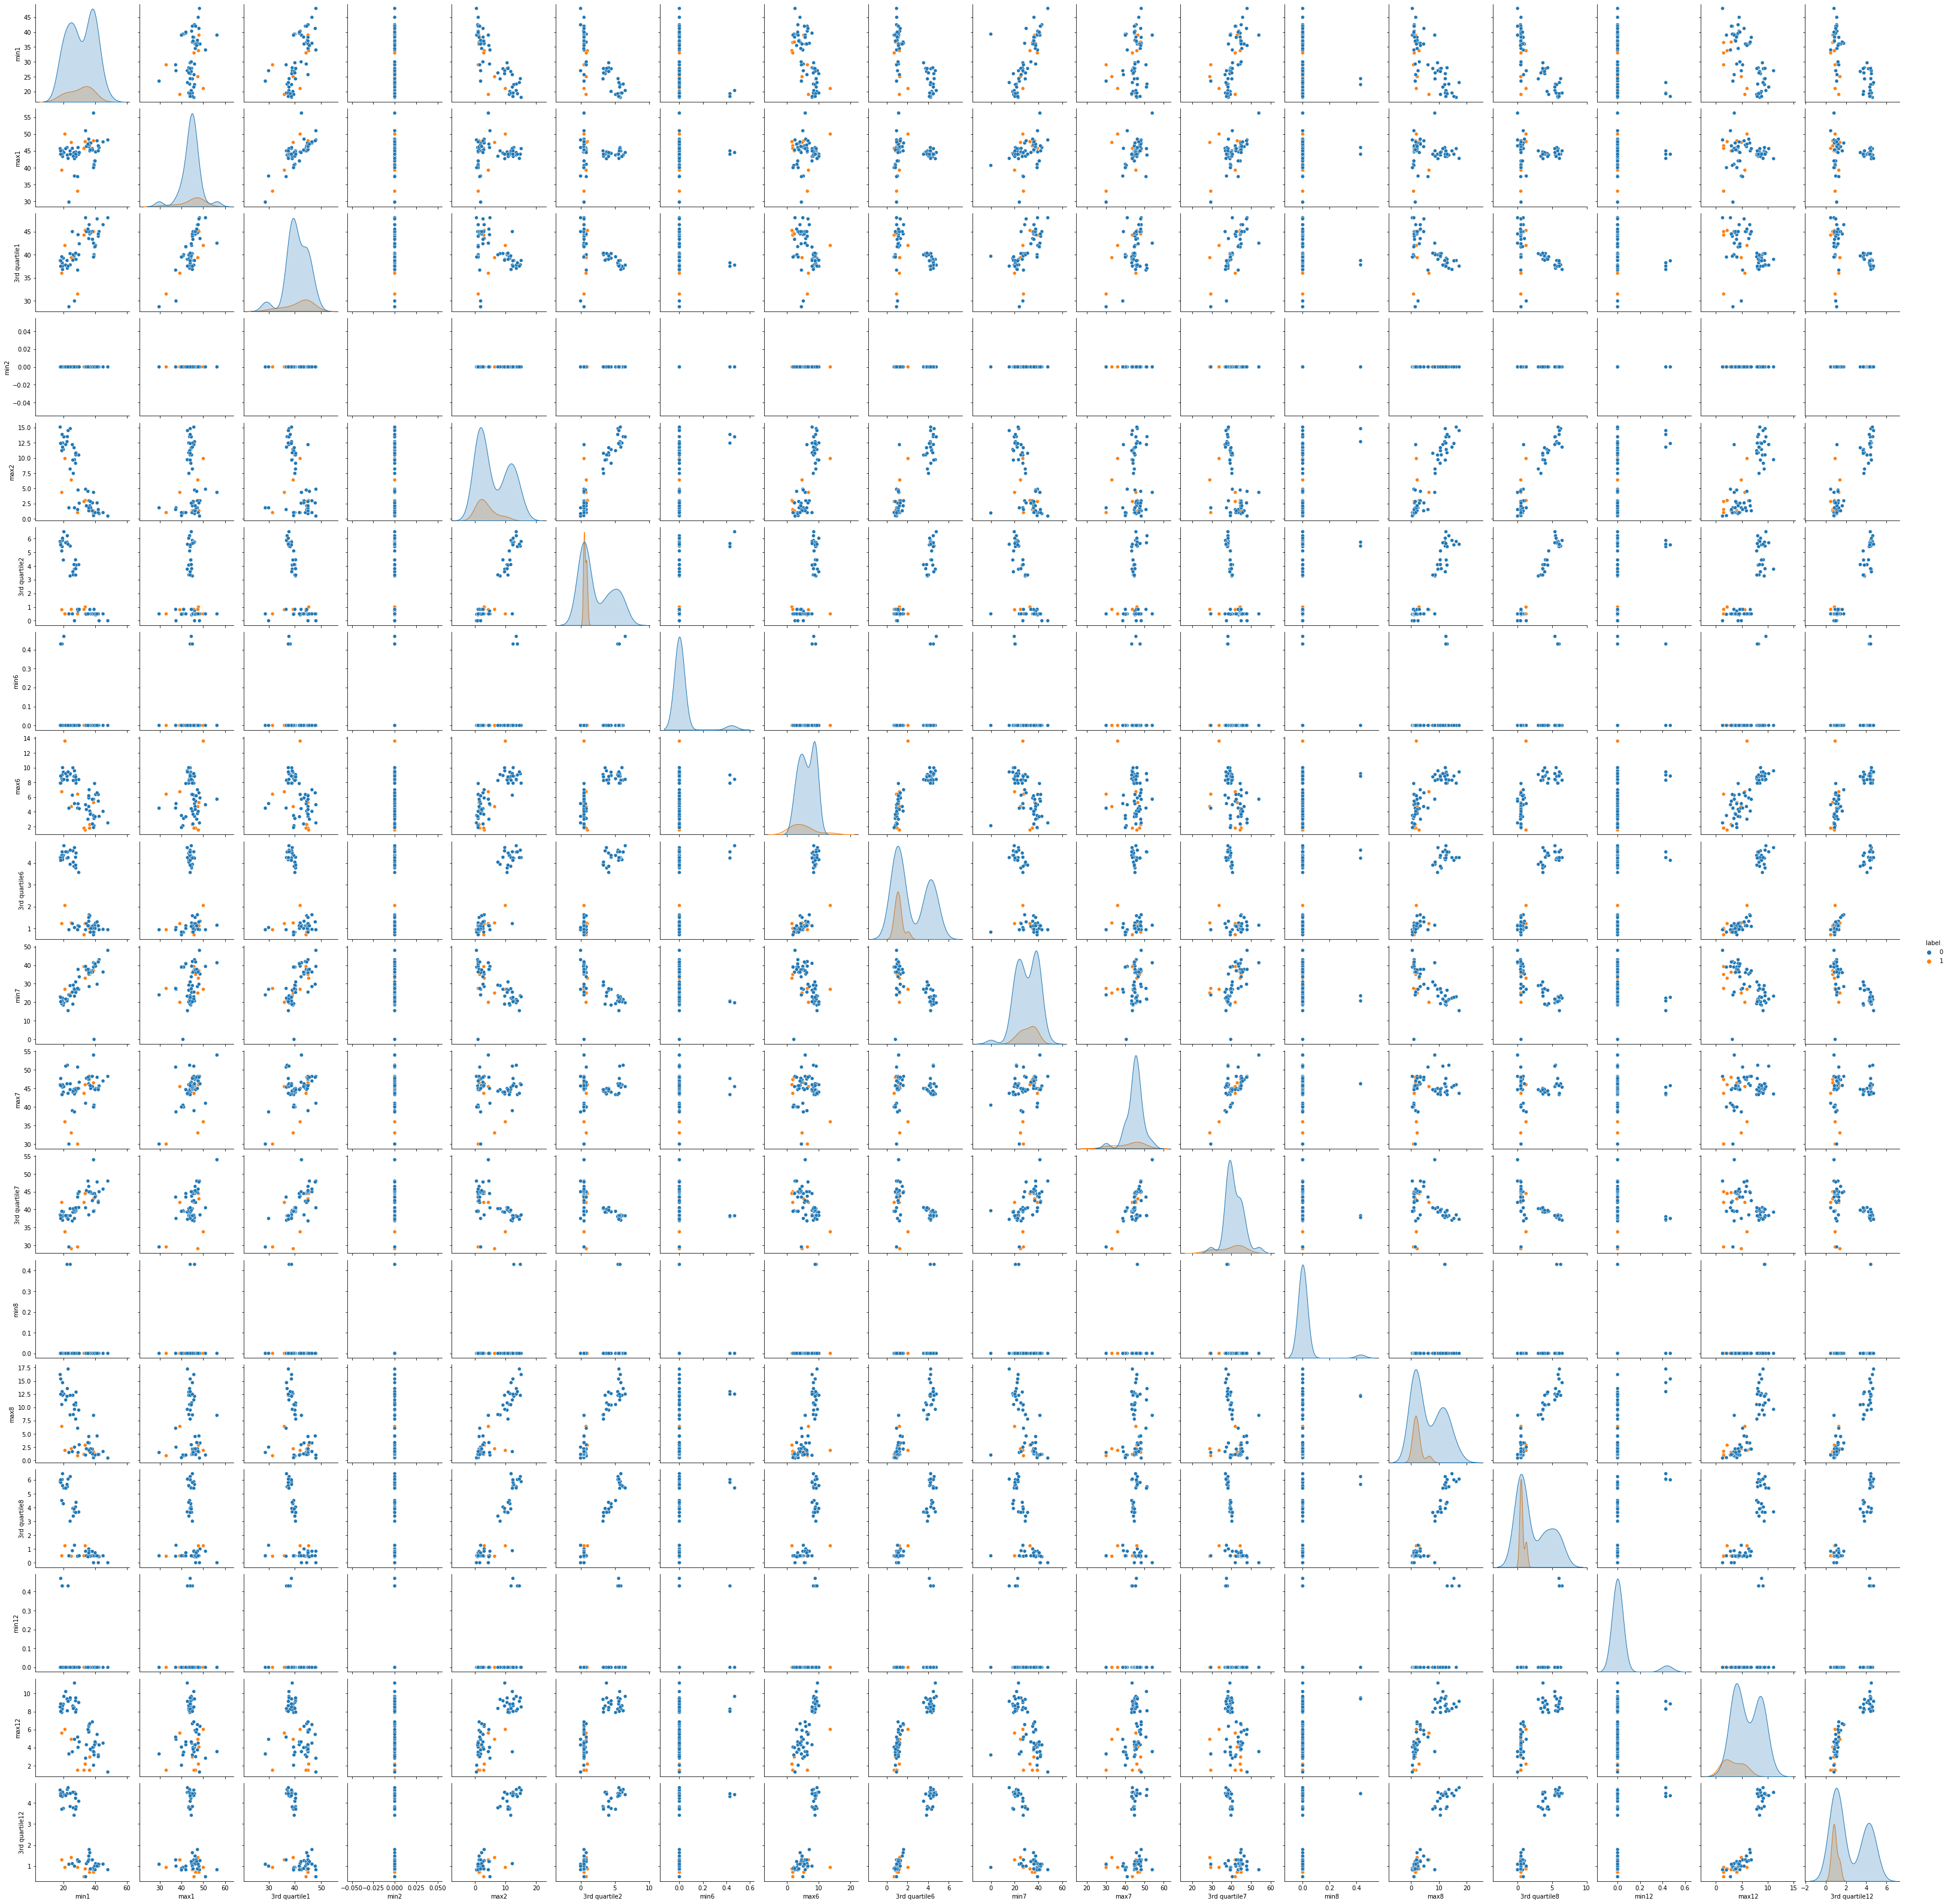

In [40]:
select_series3 = [1,2,6,7,8,12]
scatterplot(df_train_T12_label, select_features, select_series3)

### Normalized Features

In [41]:
# scatterplot(df_train_T12_norm_label, select_feature, select_series2)

### Standardize Features

In [42]:
# scatterplot(df_train_T12_std_label, select_feature, select_series2)

By comparing two plots, they are pretty similar. There is no significant difference in between, but it seems like we can have more uncorrelated features as candidates in our model

### d(iii). Break each time series in your training set into l ∈ {1,2, ...., 20}

*Method 2: backward selection using sklearn.feature selection

In [43]:
# Prepare test data
y_train_column = file_column(train_dfs, train_files)
y_test_column = file_column(test_dfs, test_files)
y_train_label = df_train_label.label
y_test_label = df_test_label.label
y_train = y_train_label.values
y_test = y_test_label.values

In [44]:
# Prepare Train Data 
def dataprep (train_dfs, test_dfs, l, select_features, index=[], scale='raw') :
    # format training/test data
    X_train = dataset_featureL(train_dfs, l, select_features, index=index, scale=scale)
    X_test = dataset_featureL(test_dfs, l, select_features, index=index, scale=scale)
    
    return X_train, X_test

In [45]:
# define logistic regression model
estimator = lm.LogisticRegression(C= 1e9, solver='lbfgs', max_iter=1e5, n_jobs=-1)
skf = StratifiedKFold(n_splits=5) # actually for binary classification cv will use skf automatically, this is not important
rfecv = RFECV(estimator,step=1, cv=skf, scoring='accuracy',n_jobs=-1)

cross_validation ref https://scikit-learn.org/stable/modules/cross_validation.html

In [46]:
# building models at different l
l_list = []
p_list = []
cv_score_mean_list = []
train_accuracy_list = []
test_accuracy_list = []
feature_list = []

for l in tqdm(range(1,21)):

    X_train, X_test = dataprep(train_dfs, test_dfs, l, select_features, scale='raw')
    selector = rfecv.fit(X_train, y_train)
    n_scores =selector.cv_results_['mean_test_score']
    cv_score_mean = np.max(n_scores)
    num_features = selector.n_features_
    y_train_pred = selector.predict(X_train)
    y_test_pred = selector.predict(X_test)
    
    train_accuracy = accuracy_score(y_train,y_train_pred)
    test_accuracy = accuracy_score(y_test,y_test_pred)
    
    l_list.append(l)
    p_list.append(num_features)
    cv_score_mean_list.append(cv_score_mean)
    train_accuracy_list.append(train_accuracy)
    test_accuracy_list.append(test_accuracy)
# construct a dataframe to store the rfecv results
result = {}
result["l"] = l_list
result["p"] = p_list
result["mean_cv_score"] = cv_score_mean_list
result["train_accuracy"] = train_accuracy_list
result["test_accuracy"] = test_accuracy_list
diii_result_table = pd.DataFrame.from_dict(result)
diii_result_table

100%|██████████| 20/20 [02:49<00:00,  8.48s/it]


,l,p,mean_cv_score,train_accuracy,test_accuracy
0,1,6,1.000000,1.000000,1.000000
1,2,8,0.985714,1.000000,1.000000
2,3,4,0.985714,1.000000,1.000000
3,4,4,0.985714,1.000000,0.947368
4,5,6,0.985714,1.000000,1.000000
5,6,5,0.985714,1.000000,1.000000
6,7,9,0.985714,1.000000,1.000000
7,8,1,0.971429,0.971014,0.947368
8,9,1,0.971429,0.956522,0.894737
9,10,11,0.971429,1.000000,1.000000


In [47]:
# find the maximum of the cross validation score mean
df_diii = pd.DataFrame(diii_result_table.loc[diii_result_table.mean_cv_score==diii_result_table.mean_cv_score.max()])
# print("The best (l, p) pair is l={}, p={}".format(int(df_diii.l[0]), int(df_diii.p[0]))
df_diii

,l,p,mean_cv_score,train_accuracy,test_accuracy
0,1,6,1.0,1.0,1.0
18,19,6,1.0,1.0,1.0


<strong>Answer</strong>
The best l, p pair:
Both (l=1 p=6)and(l=19 p=6) have the highest mean cross validation score, we choose l=1, p=6 here as the best l,p pair for the below problems

### Explain what the right way and the wrong way are to perform cross-validation in this problem

* The right way is performing K-fold cross validation with feature selection at each fold <br>
* The wrong way is performing feature selection first and start the K-fold cross validation with the same feature at each fold

### iv. Report the confusion matrix and show the ROC and AUC for your classifieron train data. Report the parameters of your logistic regression betai's as well as the p-values associated with them.

In [48]:
# define confusion matix function
def cm(model, X, y, y_predict, title):
      
    print(confusion_matrix(y, y_predict))
    # plot confusion matrix
    fig, ax = plt.subplots(1,1,figsize=(6, 6))
    plot_confusion_matrix(model, X, y, cmap=plt.cm.Blues, ax=ax) 
    ax.set_title(title,fontsize=16)
    ax.set_xlabel('Predict-label',fontsize=12)
    ax.set_ylabel('True-label',fontsize=12)
    ax.set_xticklabels(['Bending', 'Not Bending'])
    ax.set_yticklabels(['Bending', 'Not Bending'])
    plt.show()

In [49]:
# define roc curve function
def roc(y_true, y_predict, title):
    fpr, tpr, thresholds = roc_curve(y_true, y_predict, pos_label=1)
    roc_auc = auc(fpr, tpr)
    print("AUC is" , roc_auc)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.grid()
    plt.xlim([-0.05, 1])
    plt.ylim([0.0, 1.05])
    plt.legend(loc="lower right")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.show()

In [50]:
# split the data when l=1
l = df_diii.l[0]
X_train, X_test = dataprep(train_dfs, test_dfs, l, select_features, scale='raw')
# Fit the features to the response variable
clf = rfecv.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
# return selector model
log_reg_model = clf.estimator_
# Put the best features into new df X_new
# X_train_new = clf.transform(X_train)
new_features = clf.get_feature_names_out(X_train.columns)
X_train_new = X_train[new_features]

#### - Training Data Confusion Matrix

[[60  0]
 [ 0  9]]


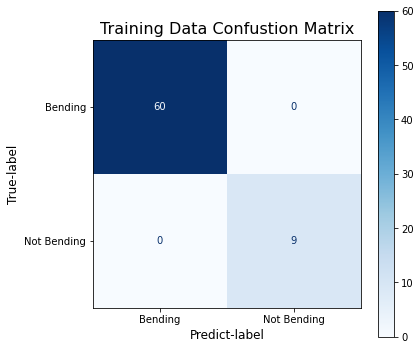

In [51]:
title = "Training Data Confustion Matrix"
cm(log_reg_model, X_train_new, y_train, y_train_pred, title)

In [52]:
class_report = classification_report(y_train, y_train_pred, target_names=['Bending', 'Not Bending'])

print("-"*55)
print("Report for Model File: ")
print("-"*55)
print(class_report)
print("-"*55)

-------------------------------------------------------
Report for Model File: 
-------------------------------------------------------
              precision    recall  f1-score   support

     Bending       1.00      1.00      1.00        60
 Not Bending       1.00      1.00      1.00         9

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69

-------------------------------------------------------


#### - Training Data ROC curve

AUC is 1.0


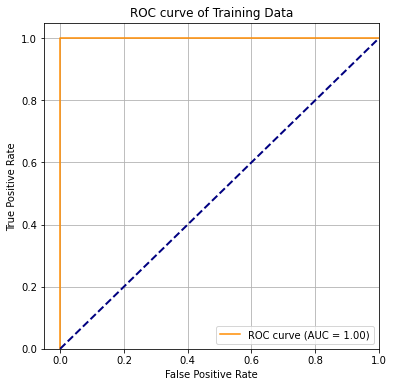

In [53]:
title = 'ROC curve of Training Data'
roc(y_train, y_train_pred, title)

#### -  Beta i's and p-values

#### scikit learn P value and Beta value calculation
P values calculation for Sklean model ref:https://gist.github.com/rspeare/77061e6e317896be29c6de9a85db301d

In [54]:
def estimate_parameters(model, X, intercept=True):
    
    p_values = []
    z_scores = []
    
    denom = (2.0*(1.0+np.cosh(model.decision_function(X))))
    if intercept:
        X = np.hstack([np.ones((X.shape[0], 1)), X])
    
    d = np.tile(denom,(X.shape[1],1)).T
    F_ij = np.dot((X/d).T,X) ## Fisher Information Matrix   
    Cramer_Rao = np.linalg.inv(F_ij) # Inverse Information Matrix
    sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
    
    if intercept:
        model_coef = np.column_stack((model.intercept_, model.coef_)) #join intercept constant and betas
    else:
        model_coef = model.coef_
        
    z_scores = (model_coef[0]/sigma_estimates) # z-score for each model coefficient
    p_values = [stat.norm.sf(abs(x))*2 for x in z_scores]
    
    return model_coef, z_scores, p_values

In [55]:
def parameter_result(model, X, intercept=True):
    
    model_coef, z_scores, p_values = estimate_parameters(model, X, intercept=intercept)
    
    temp_dict = {}  
    temp_dict['coef'] = list(model_coef[0])
    temp_dict['z'] = list(z_scores)
    temp_dict['p-value'] = p_values
    temp_df = pd.DataFrame.from_dict(temp_dict)
    
    index_list = []
    if intercept:
        for i in temp_df.index:
            if i == 0:
                index_list.append('const')
            else:
                index_list.append('beta'+str(i))
    else:
        index_list.append('beta'+str(i))
        
    temp_df.index = index_list
    
    return temp_df

In [56]:
parameter_result(log_reg_model, X_train_new, intercept=True)

,coef,z,p-value
const,-0.180132,-0.000001,0.999999
beta1,-4.012069,-0.000710,0.999433
beta2,-1.655180,-0.000271,0.999783
beta3,-1.690948,-0.000123,0.999902
beta4,3.778839,0.000879,0.999298
beta5,3.809350,0.000640,0.999489
beta6,1.671291,0.000121,0.999904


### d(v). Test the classifier on the test set. Remember that the classifier has to be tested using the features extracted from the test setCompare the accuracy on the test set with the cross-validation accuracy you obtained previously.
Note: The test dataset split step and model fitting step has done in d(iv)
also the cv_score is calculated based on accuracy

#### - Result

In [57]:
# Making prediction
X_test_new = clf.transform(X_test)
y_test_pred = log_reg_model.predict(X_test_new)
test_accuracy = accuracy_score(y_test, y_test_pred)
df_dv = pd.DataFrame(df_diii.iloc[0]).T
df_dv['test_accuracy'] = test_accuracy
df_dv

,l,p,mean_cv_score,train_accuracy,test_accuracy
0,1.0,6.0,1.0,1.0,1.0


#### - Test Data Confusion Matrix

[[15  0]
 [ 0  4]]


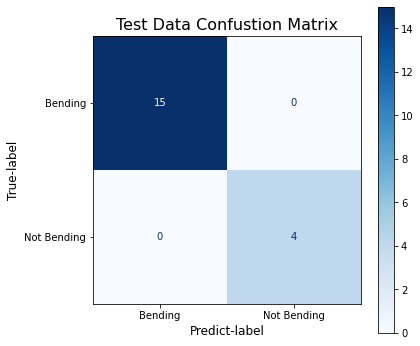

In [58]:
title = "Test Data Confustion Matrix"
cm(log_reg_model, X_test_new, y_test, y_test_pred, title)

In [59]:
class_report = classification_report(y_test, y_test_pred, target_names=['Bending', 'Not Bending'])

print("-"*55)
print("Report for Model File: ")
print("-"*55)
print(class_report)
print("-"*55)

-------------------------------------------------------
Report for Model File: 
-------------------------------------------------------
              precision    recall  f1-score   support

     Bending       1.00      1.00      1.00        15
 Not Bending       1.00      1.00      1.00         4

    accuracy                           1.00        19
   macro avg       1.00      1.00      1.00        19
weighted avg       1.00      1.00      1.00        19

-------------------------------------------------------


#### - Test Data ROC Curve

AUC is 1.0


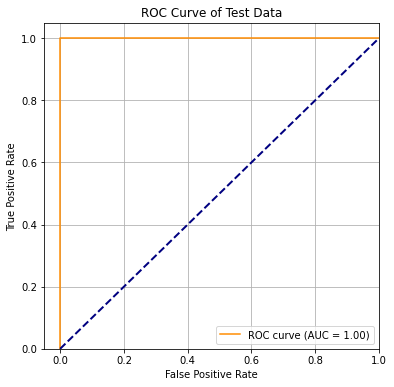

In [60]:
title = 'ROC Curve of Test Data'
roc(y_test, y_test_pred, title)

<strong>Answer</strong>: <br>
The test accuracy is 1 and the mean of cross validation score is also 1. The prediction result seems very good, one thing we need to be awared is that the test accuracy is too good, so some overfitting happend/the classes are perfectly separated when we use p-value logistic regression model to perform the training process. 

### d(vi) Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?

<strong>Answer</strong>: yes. <br>
We can tell based on the p-values we calculated from d(iv), the p-valuse are nearly 1, but the test accuracy is very high which is 1. The only reason this can happen is instability happend when we use logistic regression model the betas needs to be a very large number (infinity). So during our iteration the computer will assign decent beta i values for us, however the standard error and p-values are not realiable

### d(vii) From the confusion matrices you obtained, do you see imbalanced classes? If yes, build a logistic regression model based on case-control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model.

<strong>Answer</strong>: yes <br>
In the training result confusion matrix, there are 60 non-bending class and 9 bending class <br>
Build the logistic regression model based on the best (l,p) pair wherel=1, p=6

In [61]:
# define case control model
def downsampler(X_train, train_files):
    df_comb = add_label(X_train, train_files)
    # Separate majority and minority classes
    df_majority = df_comb[df_comb.label==0]
    df_minority = df_comb[df_comb.label==1]
    
    # Downsample majority class
    df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=3*len(df_minority),     # to match minority class
                                 random_state=42) # reproducible results
    df_downsampled = pd.concat([df_majority_downsampled, df_minority])
    
    y_downsampled = df_downsampled.label
    X_downsampled = df_downsampled.drop('label', axis=1)
    return X_downsampled, y_downsampled

In [62]:
# case control
X_downsampled, y_downsampled = downsampler(X_train_new, train_files)
# Display new class counts
print(pd.DataFrame(y_downsampled).label.value_counts())

0    27
1     9
Name: label, dtype: int64


In [63]:
# define logistic regression model
skf = StratifiedKFold(n_splits=5)
estimator2 = lm.LogisticRegression(max_iter=1e5, n_jobs=-1)
# Train model
pipe = make_pipeline(lm.LogisticRegression())
# set up params
params_space = dict(logisticregression__C=10.0**np.arange(1,9),
                    logisticregression__solver=['newton-cg', 'lbfgs'],
                    logisticregression__class_weight=[None, 'balanced'])
# all performance is still evaluated in a separated held-out 'test' set
grid = GridSearchCV(pipe, params_space, cv=skf, scoring='accuracy',n_jobs=-1)
grid.fit(X_downsampled, y_downsampled)
y_downsampled_pred = grid.predict(X_downsampled)
case_control_model = grid.best_estimator_
grid.best_params_

{'logisticregression__C': 1000.0,
 'logisticregression__class_weight': 'balanced',
 'logisticregression__solver': 'newton-cg'}

#### - Training Data Confusion Matrix

[[27  0]
 [ 0  9]]


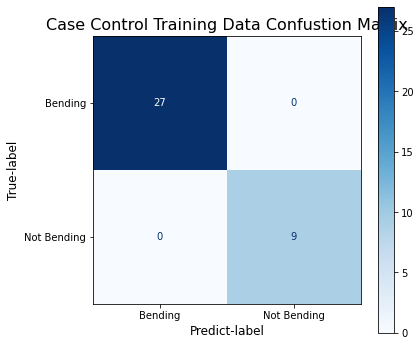

In [64]:
title = "Case Control Training Data Confustion Matrix"
cm(case_control_model, X_downsampled, y_downsampled, y_downsampled_pred, title)

In [65]:
class_report = classification_report(y_downsampled, y_downsampled_pred, target_names=['Bending', 'Not Bending'])

print("-"*55)
print("Report for Model File: ")
print("-"*55)
print(class_report)
print("-"*55)

-------------------------------------------------------
Report for Model File: 
-------------------------------------------------------
              precision    recall  f1-score   support

     Bending       1.00      1.00      1.00        27
 Not Bending       1.00      1.00      1.00         9

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36

-------------------------------------------------------


#### - Training Data ROC Curve

AUC is 1.0


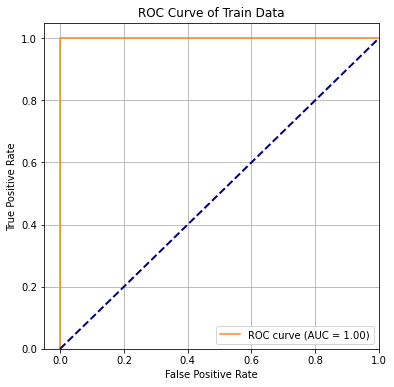

In [66]:
title = 'ROC Curve of Train Data'
roc(y_downsampled, y_downsampled_pred, title)

#### - Test Data Confusion Matrix

[[15  0]
 [ 0  4]]


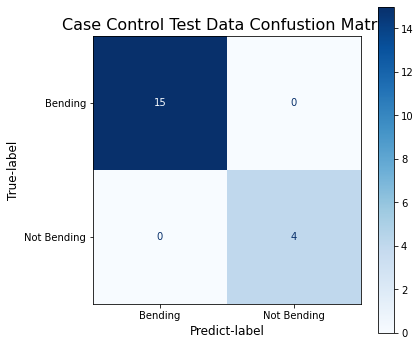

In [67]:
y_test = y_test_label.values
y_test_pred = grid.predict(X_test_new)
title = "Case Control Test Data Confustion Matrix"
cm(case_control_model, X_test_new, y_test, y_test_pred, title)

In [68]:
class_report = classification_report(y_test, y_test_pred, target_names=['Bending', 'Not Bending'])

print("-"*55)
print("Report for Model File: ")
print("-"*55)
print(class_report)
print("-"*55)

-------------------------------------------------------
Report for Model File: 
-------------------------------------------------------
              precision    recall  f1-score   support

     Bending       1.00      1.00      1.00        15
 Not Bending       1.00      1.00      1.00         4

    accuracy                           1.00        19
   macro avg       1.00      1.00      1.00        19
weighted avg       1.00      1.00      1.00        19

-------------------------------------------------------


#### - ROC Curve

AUC is 1.0


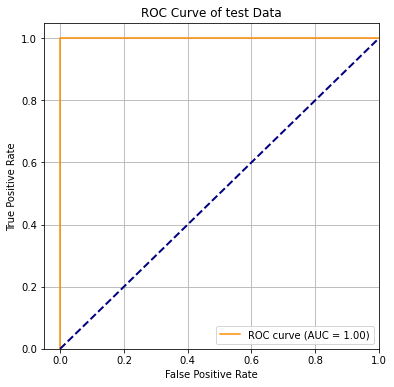

In [69]:
title = 'ROC Curve of test Data'
roc(y_test, y_test_pred, title)

## (e) Binary Classification Using L1-penalized logistic regression
### e(i) Repeat 1(d)iii using L1-penalized logistic regression

In [70]:
def L1_logreg_result(estimator, train_dfs, test_dfs, y_train, y_test, scale):
    l_list = []
    c_list = []
    cv_score_mean_list = []
    train_accuracy_list = []
    test_accuracy_list = []
    
    for l in tqdm(range(1,21)):
        X_train, X_test= dataprep(train_dfs, test_dfs, l, select_features, scale = scale)
        selector = estimator.fit(X_train, y_train)
        best_C = selector.C_[0] # best C
        Cs = selector.Cs_ # Cs
        index = np.where(Cs==best_C) # index of the best C
        cv_score_mean = selector.scores_[1].mean(axis=0) # C mean score
        best_cv_mean = cv_score_mean[index][0]
        y_train_pred = selector.predict(X_train)
        y_test_pred = selector.predict(X_test)
        y_train_accuracy = accuracy_score(y_train, y_train_pred)
        y_test_accuracy = accuracy_score(y_test, y_test_pred)
        
        l_list.append(l)
        c_list.append(best_C)
        cv_score_mean_list.append(best_cv_mean)
        train_accuracy_list.append(y_train_accuracy)
        test_accuracy_list.append(y_test_accuracy)
        
        
    result = {}
    result["l"] = l_list
    result["c"] = c_list
    result["mean_cv_score"] = cv_score_mean_list
    result["train_accuracy"] = train_accuracy_list
    result["test_accuracy"] = test_accuracy_list
    result_table = pd.DataFrame.from_dict(result)
    
    return result_table

### Raw Features

In [71]:
y_train = y_train_label.values
y_test = y_test_label.values
skf = StratifiedKFold(n_splits=5)
estimator = LogisticRegressionCV(n_jobs=-1, cv=skf, penalty='l1', scoring='accuracy', solver='liblinear')
l1_result_table = L1_logreg_result(estimator, train_dfs, test_dfs, y_train, y_test, scale='raw')
l1_result_table

100%|██████████| 20/20 [01:52<00:00,  5.61s/it]


,l,c,mean_cv_score,train_accuracy,test_accuracy
0,1,0.359381,1.000000,1.0,1.000000
1,2,21.544347,0.971429,1.0,1.000000
2,3,2.782559,0.985714,1.0,1.000000
3,4,0.359381,0.971429,1.0,0.947368
4,5,2.782559,0.957143,1.0,1.000000
5,6,0.359381,0.957143,1.0,1.000000
6,7,21.544347,0.971429,1.0,1.000000
7,8,0.359381,0.941758,1.0,0.947368
8,9,0.359381,0.957143,1.0,0.947368
9,10,0.359381,0.957143,1.0,0.947368


<Strong>Answer</Strong><br>
The best l and C pair and accuracy result:

In [72]:
df_ei = pd.DataFrame(l1_result_table.loc[l1_result_table.mean_cv_score==l1_result_table.mean_cv_score.max()])
df_ei

,l,c,mean_cv_score,train_accuracy,test_accuracy
0,1,0.359381,1.0,1.0,1.0


### Normalized Features

In [73]:
# skf = StratifiedKFold(n_splits=5)
# estimator = LogisticRegressionCV(n_jobs=-1, cv=skf, penalty='l1', scoring='accuracy', solver='liblinear')
# y_train = y_train_label.values
# y_test = y_test_label.values
# l1_result_norm_table = L1_logreg_result(estimator, train_dfs, test_dfs, y_train, y_test, scale='norm')
# l1_result_norm_table

<Strong>Answer</Strong><br>
The best l and C pair:
I use minmaxScaler(), the answer are all the same, it is not a good choice to normalize timeseries data by using this scaler otherwise I made it wrong. Please do not deduct any points here, this is just for research purpose

### Standardized Features (Based on original file)

In [74]:
skf = StratifiedKFold(n_splits=5)
estimator = LogisticRegressionCV(n_jobs=-1, cv=skf, penalty='l1', scoring='accuracy', solver='liblinear') 
y_train = y_train_label.values
y_test = y_test_label.values
l1_result_std_table = L1_logreg_result(estimator, train_dfs, test_dfs, y_train, y_test, scale='std')
l1_result_std_table

100%|██████████| 20/20 [01:56<00:00,  5.81s/it]


,l,c,mean_cv_score,train_accuracy,test_accuracy
0,1,0.000100,0.870330,0.869565,0.789474
1,2,0.000100,0.870330,0.869565,0.789474
2,3,1291.549665,0.900000,1.000000,0.736842
3,4,0.000100,0.870330,0.869565,0.789474
4,5,0.000100,0.870330,0.869565,0.789474
5,6,1291.549665,0.900000,1.000000,0.684211
6,7,2.782559,0.871429,1.000000,0.736842
7,8,1291.549665,0.885714,1.000000,0.684211
8,9,0.000100,0.870330,0.869565,0.789474
9,10,10000.000000,0.885714,1.000000,0.736842


<Strong>Answer</Strong><br>
The best l and C pair:

In [75]:
df_ei_std = pd.DataFrame(l1_result_std_table.loc[l1_result_std_table.mean_cv_score==l1_result_std_table.mean_cv_score.max()])
df_ei_std

,l,c,mean_cv_score,train_accuracy,test_accuracy
2,3,1291.549665,0.9,1.0,0.736842
5,6,1291.549665,0.9,1.0,0.684211


### Standardized Features (Based on feature table)

In [76]:
skf = StratifiedKFold(n_splits=5)
estimator = LogisticRegressionCV(n_jobs=-1, cv=skf, penalty='l1', scoring='accuracy', solver='liblinear') 
y_train = y_train_label.values
y_test = y_test_label.values
# l1_result_std_table = L1_logreg_result(estimator, train_dfs, test_dfs, y_train, y_test, scale='std')
# l1_result_std_table


In [78]:
l_list = []
c_list = []
cv_score_mean_list = []
train_accuracy_list = []
test_accuracy_list = []

for l in tqdm(range(1,21)):
    X_train, X_test= dataprep(train_dfs, test_dfs, l, select_features, scale = 'raw')
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    selector = estimator.fit(X_train, y_train)
    best_C = selector.C_[0] # best C
    Cs = selector.Cs_ # Cs
    index = np.where(Cs==best_C) # index of the best C
    cv_score_mean = selector.scores_[1].mean(axis=0) # C mean score
    best_cv_mean = cv_score_mean[index][0]
    y_train_pred = selector.predict(X_train)
    y_test_pred = selector.predict(X_test)
    y_train_accuracy = accuracy_score(y_train, y_train_pred)
    y_test_accuracy = accuracy_score(y_test, y_test_pred)

    l_list.append(l)
    c_list.append(best_C)
    cv_score_mean_list.append(best_cv_mean)
    train_accuracy_list.append(y_train_accuracy)
    test_accuracy_list.append(y_test_accuracy)


result = {}
result["l"] = l_list
result["c"] = c_list
result["mean_cv_score"] = cv_score_mean_list
result["train_accuracy"] = train_accuracy_list
result["test_accuracy"] = test_accuracy_list
l1_result_stdf = pd.DataFrame.from_dict(result)

100%|██████████| 20/20 [01:52<00:00,  5.60s/it]


In [80]:
df_ei_stdf = pd.DataFrame(l1_result_stdf.loc[l1_result_stdf.mean_cv_score==l1_result_stdf.mean_cv_score.max()])
df_ei_stdf

,l,c,mean_cv_score,train_accuracy,test_accuracy
0,1,0.359381,0.971429,0.985507,0.894737
2,3,0.359381,0.971429,0.971014,0.894737
3,4,0.359381,0.971429,0.971014,0.894737
6,7,21.544347,0.971429,1.000000,0.947368


### e(ii). Compare the L1-penalized with variable selection using p-values. Which one performs better? Which one is easier to implement?

* p-value selection by RFECV best l,p pair result

In [81]:
df_dv

,l,p,mean_cv_score,train_accuracy,test_accuracy
0,1.0,6.0,1.0,1.0,1.0


* L1-penalize logistic regression best l,c pair result (raw feature)

In [82]:
df_ei

,l,c,mean_cv_score,train_accuracy,test_accuracy
0,1,0.359381,1.0,1.0,1.0


* L1-penalize logistic regression best l,c pair result (standardized feature) <br>
Note the StandardScaler function to standardized data cause too many digits after decimal, it may cause some instability when use L1-penalized logistic regression method, the C value is not consistant, but the best mean_cv_score is the same

In [83]:
df_ei_std

,l,c,mean_cv_score,train_accuracy,test_accuracy
2,3,1291.549665,0.9,1.0,0.736842
5,6,1291.549665,0.9,1.0,0.684211


* L1-penalize logistic regression best l,c pair result (Standardized based on feature table)

In [84]:
df_ei_stdf

,l,c,mean_cv_score,train_accuracy,test_accuracy
0,1,0.359381,0.971429,0.985507,0.894737
2,3,0.359381,0.971429,0.971014,0.894737
3,4,0.359381,0.971429,0.971014,0.894737
6,7,21.544347,0.971429,1.000000,0.947368


<strong>Answer</strong> <br>
* By comparing the raw features, the accuracy of L1-penalized and p-value selection methods are pretty much the same, the best mean cross validation score of L1-penalized method is the same as the p-value selection method. But if we standarized the training data based on the original file, the L1-penailzed model's accuracy becomes slightly lower. However, if we standarized data based on feature table, the result is much better than the original std version
* By comparing the test result accuracy p-value selection is better. However, we need to be aware the way we use in model selection is not pure p-value selection, we use a backward p-value selection this could be much better than only performing p-value selection.The trade of is running time will be very long since it needs to do feature selection in each fold at different number of features.
* If we only comparing the accuracy at differet l, in general p-value selection method is better.
* The L1-penalized method is easier to implement, since it selected all features together, however the p-value selection method is selecting feature at each fold and each l, therefore the running time of L1-penalized method is shorter.
* Standardized features may not a good choice for time series data

## (f) Multi-class Classification (The Realistic Case)

### f(i) Find the best l in the same way as you found it in 1(e)i to build an L1-penalized multinomial regression model to classify all activities in your training set. Report your test error. Research how confusion matrices and ROC curves are defined for multiclass classification and show them for this problem if possible

In [85]:
def dataprep_multi (train_dfs, test_dfs, y_train_column, y_test_column, l, select_features, index=[], scale='raw') :
    # call dataset_featureL to extract and rename features
    X_train = dataset_featureL(train_dfs, l, select_features, index=index, scale=scale) # call dataset_featureL
    X_test = dataset_featureL(test_dfs, l, select_features, index=index, scale=scale)
    y_train_column_new = [ "bending" if (x=="bending1" or x=="bending2") else x for x in y_train_column]
    y_test_column_new = [ "bending" if (x=="bending1" or x=="bending2") else x for x in y_test_column]
    
    # creating instance of labelencoder
    labelencoder = LabelEncoder()
    y_train = labelencoder.fit_transform(y_train_column_new)
    y_test = labelencoder.fit_transform(y_test_column_new)

    train_classes = labelencoder.inverse_transform(y_train)
    test_classes = labelencoder.inverse_transform(y_test)
    train_classes = list(set(train_classes))
    test_classes = list(set(test_classes))
    return X_train, X_test, y_train, y_test, train_classes, test_classes

In [86]:
def L1_multilogreg_result(estimator, train_dfs, test_dfs, y_train_column, y_test_column, scale):
    
    l_list = []
    c_list = []
    cv_score_mean_list = []
    train_accuracy_list = []
    test_accuracy_list = []
    test_error_list = []
    
    for l in tqdm(range(1,21)):
        X_train, X_test, y_train, y_test, train_classes, test_classes = dataprep_multi (train_dfs, 
                                test_dfs, y_train_column, y_test_column, l, select_features, index=[], scale=scale)
        selector = estimator.fit(X_train, y_train)
        best_C = selector.C_[0] # best C
        Cs = selector.Cs_ # Cs
        index = np.where(Cs==best_C) # index of the best C
        cv_score_mean = selector.scores_[1].mean(axis=0) # C mean score
        best_cv_mean = cv_score_mean[index][0]
        y_train_pred = selector.predict(X_train)
        y_test_pred = selector.predict(X_test)
        y_train_accuracy = accuracy_score(y_train, y_train_pred)
        y_test_accuracy = accuracy_score(y_test, y_test_pred)
        
        l_list.append(l)
        c_list.append(best_C)
        cv_score_mean_list.append(best_cv_mean)
        train_accuracy_list.append(y_train_accuracy)
        test_accuracy_list.append(y_test_accuracy)
        test_error_list.append(1-y_test_accuracy)
        
    result = {}
    result["l"] = l_list
    result["c"] = c_list
    result["mean_cv_score"] = cv_score_mean_list
    result["train_accuracy"] = train_accuracy_list
    result["test_accuracy"] = test_accuracy_list
    result["test_error"] = test_error_list
    result_table = pd.DataFrame.from_dict(result)
    
    return result_table

In [87]:
def multi_cm(model, X, y, y_predict):
      
    print(confusion_matrix(y, y_predict))
    # plot confusion matrix
    fig, ax = plt.subplots(1,1,figsize=(6, 6))
    plot_confusion_matrix(model, X, y, cmap=plt.cm.Blues, ax=ax) 
    ax.set_title("Confusion Matrix",fontsize=16)
    ax.set_xlabel('Predict-label',fontsize=12)
    ax.set_ylabel('True-label',fontsize=12)
    plt.show()

In [88]:
def plot_roc (classes, y_true, y_score):
    y_true_dummies = pd.get_dummies(y_true, drop_first=False).values
    n_classes = y_true_dummies.shape[1]
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    plt.figure(figsize=(6, 6))
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) label %s' % (roc_auc[i], classes[i]))
        

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.05, 1])
    plt.ylim([0.0, 1.05])
    plt.grid()
    plt.legend(loc="lower right")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("Multiclass ROC Curve")

In [89]:
skf = StratifiedKFold(n_splits=5)
estimator = LogisticRegressionCV(n_jobs=-1, cv=skf, penalty='l1', 
                                 multi_class='multinomial', scoring='accuracy', solver='saga')

### Raw Features

In [90]:
fi_table = L1_multilogreg_result(estimator, train_dfs, test_dfs, y_train_column, y_test_column, scale='raw')
fi_table

100%|██████████| 20/20 [01:59<00:00,  5.99s/it]


,l,c,mean_cv_score,train_accuracy,test_accuracy,test_error
0,1,21.544347,0.912088,0.985507,0.894737,0.105263
1,2,1291.549665,0.854945,1.000000,0.947368,0.052632
2,3,21.544347,0.797802,1.000000,0.842105,0.157895
3,4,2.782559,0.812088,1.000000,0.894737,0.105263
4,5,0.359381,0.827473,1.000000,0.842105,0.157895
5,6,166.810054,0.869231,1.000000,0.842105,0.157895
6,7,2.782559,0.826374,1.000000,0.842105,0.157895
7,8,2.782559,0.810989,1.000000,0.842105,0.157895
8,9,2.782559,0.813187,1.000000,0.842105,0.157895
9,10,1291.549665,0.812088,1.000000,0.842105,0.157895


<strong>Answer</strong>
The best l, c pair and test errors are shown below

In [91]:
df_fi = pd.DataFrame(fi_table.loc[fi_table.mean_cv_score==fi_table.mean_cv_score.max()])
df_fi

,l,c,mean_cv_score,train_accuracy,test_accuracy,test_error
0,1,21.544347,0.912088,0.985507,0.894737,0.105263


In [95]:
# this is used to generate data for confusion matix and roc curve
l=df_fi.l[0]
c=df_fi.c[0]
skf = StratifiedKFold(n_splits=5)
estimator = LogisticRegressionCV(n_jobs=-1, cv=skf, penalty='l1', Cs=[c],
                                 multi_class='multinomial', scoring='accuracy', solver='saga')
X_train, X_test, y_train, y_test, train_classes, test_classes = dataprep_multi (train_dfs, test_dfs, y_train_column, y_test_column,
                                                           l, select_features, index=[], scale='raw')

selector = estimator.fit(X_train, y_train)
y_train_pred = selector.predict(X_train)
y_test_pred = selector.predict(X_test)
y_train_score = selector.decision_function(X_train)
y_test_score = selector.decision_function(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

#### - Training Data Confusion Matrix (Raw Features)

[[ 9  0  0  0  0  0]
 [ 0 12  0  0  0  0]
 [ 0  0 12  0  0  0]
 [ 0  0  0 12  0  0]
 [ 0  0  0  1 11  0]
 [ 0  0  0  0  0 12]]


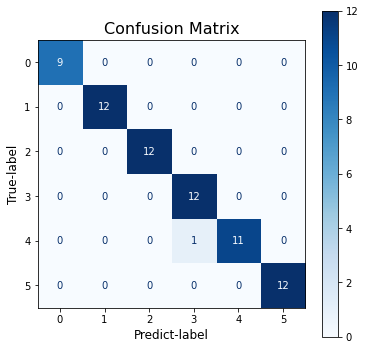

In [96]:
multi_cm(selector, X_train, y_train, y_train_pred)

In [97]:
class_report = classification_report(y_train, y_train_pred, target_names=train_classes)

print("-"*55)
print("Report for Model File: ")
print("-"*55)
print(class_report)
print("-"*55)

-------------------------------------------------------
Report for Model File: 
-------------------------------------------------------
              precision    recall  f1-score   support

     sitting       1.00      1.00      1.00         9
     cycling       1.00      1.00      1.00        12
     bending       1.00      1.00      1.00        12
     walking       0.92      1.00      0.96        12
       lying       1.00      0.92      0.96        12
    standing       1.00      1.00      1.00        12

    accuracy                           0.99        69
   macro avg       0.99      0.99      0.99        69
weighted avg       0.99      0.99      0.99        69

-------------------------------------------------------


#### - Training Data ROC Curve ( Raw Features )

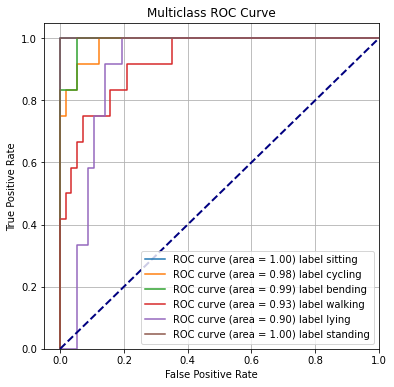

In [98]:
plot_roc (train_classes, y_train, y_train_score)

#### - Test Data Confusion Matrix (Raw Features)

[[4 0 0 0 0 0]
 [0 2 0 0 0 1]
 [0 0 3 0 0 0]
 [0 0 0 3 0 0]
 [0 0 1 0 2 0]
 [0 0 0 0 0 3]]


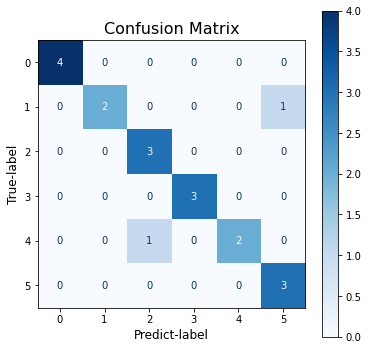

In [99]:
multi_cm(selector, X_test, y_test, y_test_pred)

In [100]:
class_report = classification_report(y_test, y_test_pred, target_names=test_classes)

print("-"*55)
print("Report for Model File: ")
print("-"*55)
print(class_report)
print("-"*55)

-------------------------------------------------------
Report for Model File: 
-------------------------------------------------------
              precision    recall  f1-score   support

     sitting       1.00      1.00      1.00         4
     cycling       1.00      0.67      0.80         3
     bending       0.75      1.00      0.86         3
     walking       1.00      1.00      1.00         3
       lying       1.00      0.67      0.80         3
    standing       0.75      1.00      0.86         3

    accuracy                           0.89        19
   macro avg       0.92      0.89      0.89        19
weighted avg       0.92      0.89      0.89        19

-------------------------------------------------------


#### - Test Data ROC Curve ( Raw Features )

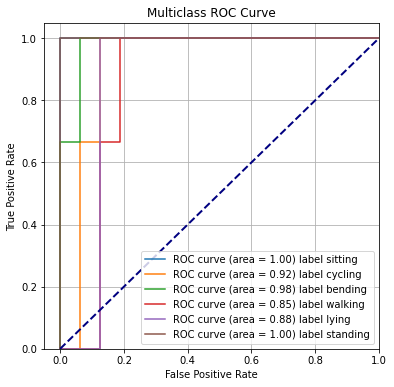

In [101]:
plot_roc (test_classes, y_test, y_test_score)

### Standardize Features (Original File)

In [102]:
skf = StratifiedKFold(n_splits=5)
estimator = LogisticRegressionCV(n_jobs=-1, cv=skf, penalty='l1', 
                                 multi_class='multinomial', scoring='accuracy', solver='saga')
fi_table_std = L1_multilogreg_result(estimator, train_dfs, test_dfs, y_train_column, y_test_column, scale='std')
fi_table_std

100%|██████████| 20/20 [02:03<00:00,  6.16s/it]


,l,c,mean_cv_score,train_accuracy,test_accuracy,test_error
0,1,21.544347,0.638462,0.855072,0.631579,0.368421
1,2,10000.000000,0.548352,1.000000,0.526316,0.473684
2,3,21.544347,0.620879,1.000000,0.578947,0.421053
3,4,2.782559,0.579121,1.000000,0.578947,0.421053
4,5,2.782559,0.549451,1.000000,0.473684,0.526316
5,6,2.782559,0.609890,1.000000,0.526316,0.473684
6,7,1291.549665,0.582418,1.000000,0.631579,0.368421
7,8,2.782559,0.494505,1.000000,0.578947,0.421053
8,9,2.782559,0.446154,1.000000,0.421053,0.578947
9,10,2.782559,0.449451,1.000000,0.473684,0.526316


<Strong>Answer</Strong><br>
The best l and C pair are shown below:

In [103]:
df_fi_std = pd.DataFrame(fi_table_std.loc[fi_table_std.mean_cv_score==fi_table_std.mean_cv_score.max()])
df_fi_std

,l,c,mean_cv_score,train_accuracy,test_accuracy,test_error
0,1,21.544347,0.638462,0.855072,0.631579,0.368421


In [104]:
# this is used to generate data for confusion matix and roc curve
l=df_fi.l[0]
c=df_fi.c[0]
skf = StratifiedKFold(n_splits=5)

X_train, X_test, y_train, y_test, train_classes, test_classes = dataprep_multi (train_dfs, test_dfs, y_train_column, 
                                                                                y_test_column,l, select_features, 
                                                                                index=[], scale='std')

selector = estimator.fit(X_train, y_train)
y_train_pred = selector.predict(X_train)
y_test_pred = selector.predict(X_test)
y_train_score = selector.decision_function(X_train)
y_test_score = selector.decision_function(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

#### - Training Data Confusion Matrix (Standardized features)

[[ 6  1  1  1  0  0]
 [ 0 11  0  0  0  1]
 [ 0  0 10  2  0  0]
 [ 2  0  1  9  0  0]
 [ 0  0  0  1 11  0]
 [ 0  0  0  0  0 12]]


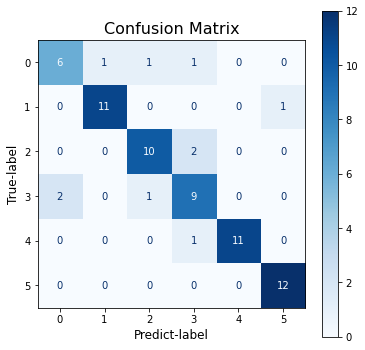

In [105]:
multi_cm(selector, X_train, y_train, y_train_pred)

In [106]:
class_report = classification_report(y_train, y_train_pred, target_names=train_classes)

print("-"*55)
print("Report for Model File: ")
print("-"*55)
print(class_report)
print("-"*55)

-------------------------------------------------------
Report for Model File: 
-------------------------------------------------------
              precision    recall  f1-score   support

     sitting       0.75      0.67      0.71         9
     cycling       0.92      0.92      0.92        12
     bending       0.83      0.83      0.83        12
     walking       0.69      0.75      0.72        12
       lying       1.00      0.92      0.96        12
    standing       0.92      1.00      0.96        12

    accuracy                           0.86        69
   macro avg       0.85      0.85      0.85        69
weighted avg       0.86      0.86      0.85        69

-------------------------------------------------------


#### - Training Data ROC Curve (Standardized features)

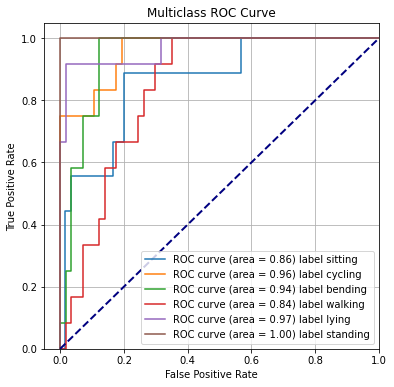

In [107]:
plot_roc (train_classes, y_train, y_train_score)

#### - Test Data Confusion Matrix (Standardized features)

[[3 0 1 0 0 0]
 [0 1 0 0 0 2]
 [0 0 2 0 1 0]
 [1 0 1 1 0 0]
 [0 0 0 1 2 0]
 [0 0 0 0 0 3]]


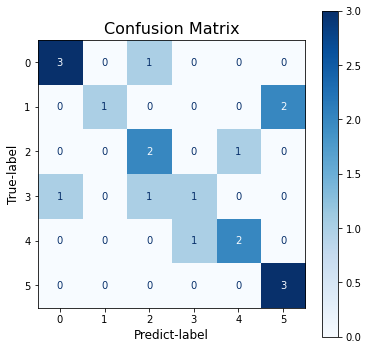

In [108]:
multi_cm(selector, X_test, y_test, y_test_pred)

In [109]:
class_report = classification_report(y_test, y_test_pred, target_names=test_classes)

print("-"*55)
print("Report for Model File: ")
print("-"*55)
print(class_report)
print("-"*55)

-------------------------------------------------------
Report for Model File: 
-------------------------------------------------------
              precision    recall  f1-score   support

     sitting       0.75      0.75      0.75         4
     cycling       1.00      0.33      0.50         3
     bending       0.50      0.67      0.57         3
     walking       0.50      0.33      0.40         3
       lying       0.67      0.67      0.67         3
    standing       0.60      1.00      0.75         3

    accuracy                           0.63        19
   macro avg       0.67      0.62      0.61        19
weighted avg       0.67      0.63      0.61        19

-------------------------------------------------------


#### - Test Data ROC Curve (Standardized features)

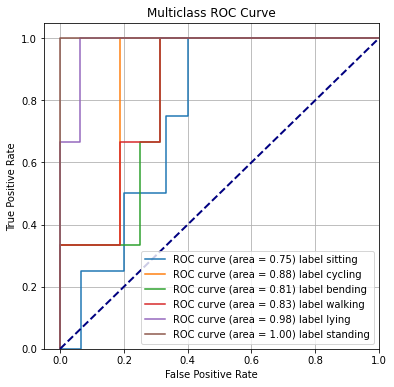

In [110]:
plot_roc (test_classes, y_test, y_test_score)

### Standardize Features (Based on Feature Table)

In [111]:
l_list = []
c_list = []
cv_score_mean_list = []
train_accuracy_list = []
test_accuracy_list = []
test_error_list = []

for l in tqdm(range(1,21)):
    X_train, X_test, y_train, y_test, train_classes, test_classes = dataprep_multi (train_dfs, 
                            test_dfs, y_train_column, y_test_column, l, select_features, index=[], scale='raw')
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    selector = estimator.fit(X_train, y_train)
    best_C = selector.C_[0] # best C
    Cs = selector.Cs_ # Cs
    index = np.where(Cs==best_C) # index of the best C
    cv_score_mean = selector.scores_[1].mean(axis=0) # C mean score
    best_cv_mean = cv_score_mean[index][0]
    y_train_pred = selector.predict(X_train)
    y_test_pred = selector.predict(X_test)
    y_train_accuracy = accuracy_score(y_train, y_train_pred)
    y_test_accuracy = accuracy_score(y_test, y_test_pred)

    l_list.append(l)
    c_list.append(best_C)
    cv_score_mean_list.append(best_cv_mean)
    train_accuracy_list.append(y_train_accuracy)
    test_accuracy_list.append(y_test_accuracy)
    test_error_list.append(1-y_test_accuracy)

result = {}
result["l"] = l_list
result["c"] = c_list
result["mean_cv_score"] = cv_score_mean_list
result["train_accuracy"] = train_accuracy_list
result["test_accuracy"] = test_accuracy_list
result["test_error"] = test_error_list
result_table = pd.DataFrame.from_dict(result)
result_table

100%|██████████| 20/20 [01:59<00:00,  5.96s/it]


,l,c,mean_cv_score,train_accuracy,test_accuracy,test_error
0,1,2.782559,0.884615,0.985507,0.947368,0.052632
1,2,166.810054,0.884615,1.000000,0.894737,0.105263
2,3,1291.549665,0.839560,1.000000,0.894737,0.105263
3,4,21.544347,0.840659,1.000000,0.789474,0.210526
4,5,10000.000000,0.810989,1.000000,0.789474,0.210526
5,6,21.544347,0.856044,1.000000,0.789474,0.210526
6,7,1291.549665,0.825275,1.000000,0.842105,0.157895
7,8,21.544347,0.810989,1.000000,0.842105,0.157895
8,9,1291.549665,0.826374,1.000000,0.842105,0.157895
9,10,21.544347,0.840659,1.000000,0.894737,0.105263


<Strong>Answer</Strong><br>
The best l and C pair are shown below:

In [150]:
df_fi_stdf = pd.DataFrame(result_table.loc[result_table.mean_cv_score==result_table.mean_cv_score.max()])
df_fi_stdf

,l,c,mean_cv_score,train_accuracy,test_accuracy,test_error
0,1,2.782559,0.884615,0.985507,0.947368,0.052632
1,2,166.810054,0.884615,1.000000,0.894737,0.105263


In [120]:
# this is used to generate data for confusion matix and roc curve
l=df_fi.l[0]
c=df_fi.c[0]
skf = StratifiedKFold(n_splits=5)

X_train, X_test, y_train, y_test, train_classes, test_classes = dataprep_multi (train_dfs, test_dfs, y_train_column, 
                                                                                y_test_column,l, select_features, index=[], scale='std')

scaler = StandardScaler()                                                                           
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
selector = estimator.fit(X_train, y_train)
y_train_pred = selector.predict(X_train)
y_test_pred = selector.predict(X_test)
y_train_score = selector.decision_function(X_train)
y_test_score = selector.decision_function(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

#### - Training Data Confusion Matrix (Standardized based on feature table)

[[ 7  0  1  0  1  0]
 [ 0 10  0  0  0  2]
 [ 0  0 10  2  0  0]
 [ 1  0  2  8  1  0]
 [ 1  0  0  1 10  0]
 [ 0  0  0  0  0 12]]


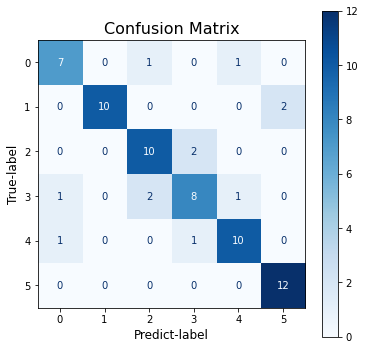

In [121]:
multi_cm(selector, X_train, y_train, y_train_pred)

In [122]:
class_report = classification_report(y_train, y_train_pred, target_names=train_classes)

print("-"*55)
print("Report for Model File: ")
print("-"*55)
print(class_report)
print("-"*55)

-------------------------------------------------------
Report for Model File: 
-------------------------------------------------------
              precision    recall  f1-score   support

     sitting       0.78      0.78      0.78         9
     cycling       1.00      0.83      0.91        12
     bending       0.77      0.83      0.80        12
     walking       0.73      0.67      0.70        12
       lying       0.83      0.83      0.83        12
    standing       0.86      1.00      0.92        12

    accuracy                           0.83        69
   macro avg       0.83      0.82      0.82        69
weighted avg       0.83      0.83      0.83        69

-------------------------------------------------------


#### - Training Data ROC Curve (Standardized based on feature table)

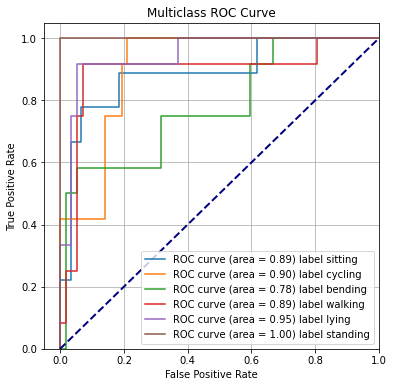

In [123]:
plot_roc (train_classes, y_train, y_train_score)

#### - Test Data Confusion Matrix (Standardized based on feature table)

[[1 0 0 2 1 0]
 [0 1 0 0 0 2]
 [1 0 2 0 0 0]
 [1 0 0 2 0 0]
 [0 0 0 1 2 0]
 [0 0 0 0 0 3]]


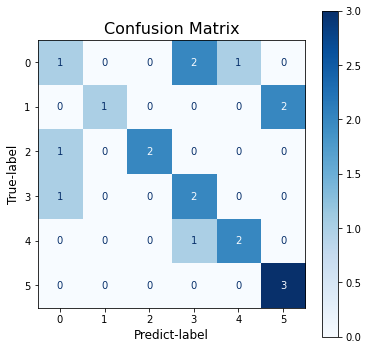

In [124]:
multi_cm(selector, X_test, y_test, y_test_pred)

In [125]:
class_report = classification_report(y_test, y_test_pred, target_names=test_classes)

print("-"*55)
print("Report for Model File: ")
print("-"*55)
print(class_report)
print("-"*55)

-------------------------------------------------------
Report for Model File: 
-------------------------------------------------------
              precision    recall  f1-score   support

     sitting       0.33      0.25      0.29         4
     cycling       1.00      0.33      0.50         3
     bending       1.00      0.67      0.80         3
     walking       0.40      0.67      0.50         3
       lying       0.67      0.67      0.67         3
    standing       0.60      1.00      0.75         3

    accuracy                           0.58        19
   macro avg       0.67      0.60      0.58        19
weighted avg       0.65      0.58      0.57        19

-------------------------------------------------------


#### - Test Data ROC Curve (Standardized based on feature table)

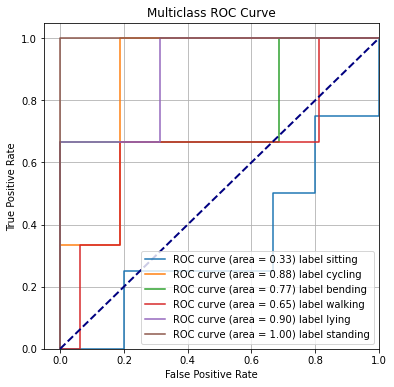

In [126]:
plot_roc (test_classes, y_test, y_test_score)

### f(ii). Repeat 1(f)i using a Naive Bayes' classifier. Use both Gaussian and Multinomial priors and compare the results.

In [127]:
def NB_result(estimator, train_dfs, test_dfs, y_train_column, y_test_column, select_features, index=[], scale='std'):
    l_list = []
    cv_score_mean_list = []
    train_accuracy_list = []
    test_accuracy_list = []
    test_error_list = []

    for l in tqdm(range(1,21)):
        X_train, X_test, y_train, y_test, train_classes, test_classes = dataprep_multi (train_dfs, test_dfs, 
                                                y_train_column, y_test_column,l, select_features, index=[], scale=scale)
        
        cv_score = cross_val_score(estimator, X_train, y_train, cv=skf, scoring='accuracy',n_jobs=-1)
        selector = estimator.fit(X_train, y_train)
        y_test_pred = selector.predict(X_test)
        y_train_pred = selector.predict(X_train)
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        test_error = 1-test_accuracy
        cv_score_mean = np.mean(cv_score)

        l_list.append(l)
        cv_score_mean_list.append(cv_score_mean)
        train_accuracy_list.append(train_accuracy)
        test_accuracy_list.append(test_accuracy)
        test_error_list.append(test_error)

    # construct a dataframe to store the l1 logistic regression results
    result = {}
    result["l"] = l_list
    result["mean_cv_score"] = cv_score_mean_list
    result["train_accuracy"] = train_accuracy_list
    result["test_accuracy"] = test_accuracy_list
    result["test_error"] = test_error_list
    result_table = pd.DataFrame.from_dict(result)
    return result_table

### - Gasussian
### Raw Features

In [128]:
estimator = GaussianNB()
result_table_GNB = NB_result(estimator, train_dfs, test_dfs, y_train_column, y_test_column, select_features, scale='raw')
result_table_GNB

100%|██████████| 20/20 [01:54<00:00,  5.72s/it]


,l,mean_cv_score,train_accuracy,test_accuracy,test_error
0,1,0.898901,0.971014,0.947368,0.052632
1,2,0.884615,0.985507,1.000000,0.000000
2,3,0.782418,0.971014,0.842105,0.157895
3,4,0.753846,0.942029,0.947368,0.052632
4,5,0.738462,0.927536,0.894737,0.105263
5,6,0.696703,0.956522,0.789474,0.210526
6,7,0.738462,0.956522,0.789474,0.210526
7,8,0.753846,0.956522,0.842105,0.157895
8,9,0.636264,1.000000,0.842105,0.157895
9,10,0.650549,0.956522,0.736842,0.263158


<Strong>Answer</Strong><br>
The best l is shown below:

In [129]:
df_fii_GNB = pd.DataFrame(result_table_GNB.loc[result_table_GNB.mean_cv_score==result_table_GNB.mean_cv_score.max()])
df_fii_GNB

,l,mean_cv_score,train_accuracy,test_accuracy,test_error
0,1,0.898901,0.971014,0.947368,0.052632


In [130]:
l= int(df_fii_GNB.l)
X_train, X_test, y_train, y_test, train_classes, test_classes = dataprep_multi (train_dfs, test_dfs, 
                                            y_train_column, y_test_column,l, select_features, index=[], scale='raw')

selector = estimator.fit(X_train, y_train)
y_train_pred = selector.predict(X_train)
y_test_pred = selector.predict(X_test)
y_train_score = selector.predict_proba(X_train)
y_test_score = selector.predict_proba(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

#### - Training Data Confusion Matrix (Raw Features)

[[ 8  0  1  0  0  0]
 [ 0 12  0  0  0  0]
 [ 0  0 12  0  0  0]
 [ 0  0  0 11  1  0]
 [ 0  0  0  0 12  0]
 [ 0  0  0  0  0 12]]


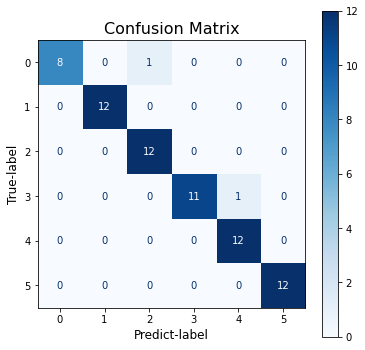

In [131]:
multi_cm(selector, X_train, y_train, y_train_pred)

In [132]:
class_report = classification_report(y_train, y_train_pred, target_names=train_classes)

print("-"*55)
print("Report for Model File: ")
print("-"*55)
print(class_report)
print("-"*55)

-------------------------------------------------------
Report for Model File: 
-------------------------------------------------------
              precision    recall  f1-score   support

     sitting       1.00      0.89      0.94         9
     cycling       1.00      1.00      1.00        12
     bending       0.92      1.00      0.96        12
     walking       1.00      0.92      0.96        12
       lying       0.92      1.00      0.96        12
    standing       1.00      1.00      1.00        12

    accuracy                           0.97        69
   macro avg       0.97      0.97      0.97        69
weighted avg       0.97      0.97      0.97        69

-------------------------------------------------------


#### - Training Data ROC Curve (Raw Features)

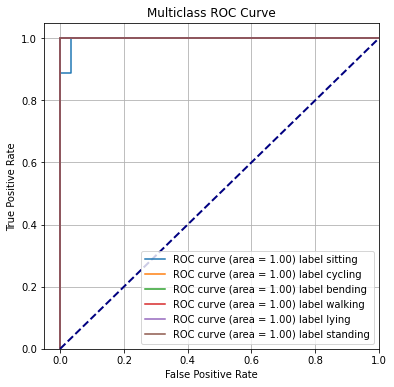

In [133]:
plot_roc (train_classes, y_train, y_train_score)

#### - Test Data Confusion Matrix ( Raw Features )

[[4 0 0 0 0 0]
 [0 3 0 0 0 0]
 [1 0 2 0 0 0]
 [0 0 0 3 0 0]
 [0 0 0 0 3 0]
 [0 0 0 0 0 3]]


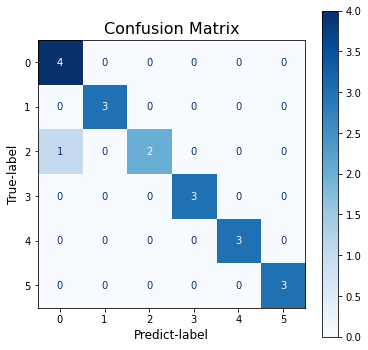

In [134]:
multi_cm(selector, X_test, y_test, y_test_pred)

In [135]:
class_report = classification_report(y_test, y_test_pred, target_names=test_classes)

print("-"*55)
print("Report for Model File: ")
print("-"*55)
print(class_report)
print("-"*55)

-------------------------------------------------------
Report for Model File: 
-------------------------------------------------------
              precision    recall  f1-score   support

     sitting       0.80      1.00      0.89         4
     cycling       1.00      1.00      1.00         3
     bending       1.00      0.67      0.80         3
     walking       1.00      1.00      1.00         3
       lying       1.00      1.00      1.00         3
    standing       1.00      1.00      1.00         3

    accuracy                           0.95        19
   macro avg       0.97      0.94      0.95        19
weighted avg       0.96      0.95      0.95        19

-------------------------------------------------------


#### - Test Data ROC Curve ( Raw Features )

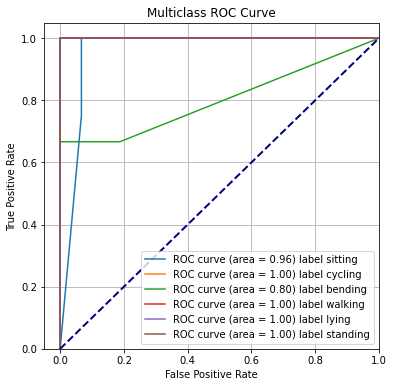

In [136]:
plot_roc (test_classes, y_test, y_test_score)

### - Multinomial Priors

In [137]:
# define logistic regression model
skf = StratifiedKFold(n_splits=5)
# Train model
pipe = make_pipeline(MultinomialNB())
# set up params
params_space = dict(multinomialnb__alpha=np.arange(0.0, 1.0, 0.01))
# all performance is still evaluated in a separated held-out 'test' set
grid = GridSearchCV(pipe, params_space, cv=skf, scoring='accuracy',n_jobs=-1)

In [138]:
l_list = []
alpha_list=[]
cv_score_mean_list = []
train_accuracy_list = []
test_accuracy_list = []
test_error_list = []

for l in tqdm(range(1,21)):
    X_train, X_test, y_train, y_test, train_classes, test_classes = dataprep_multi (train_dfs, test_dfs, 
                                            y_train_column, y_test_column,l, select_features, index=[], scale='raw')

    grid.fit(X_train,y_train)
    cv_score = grid.cv_results_['mean_test_score']
    y_test_pred = grid.predict(X_test)
    y_train_pred = grid.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_error = 1-test_accuracy
    cv_score_mean = np.mean(cv_score)
    
    l_list.append(l)
    alpha_list.append(grid.best_params_['multinomialnb__alpha'])
    cv_score_mean_list.append(cv_score_mean)
    train_accuracy_list.append(train_accuracy)
    test_accuracy_list.append(test_accuracy)
    test_error_list.append(test_error)

# construct a dataframe to store the l1 logistic regression results
result = {}
result["l"] = l_list
result["alpha"] = alpha_list
result["mean_cv_score"] = cv_score_mean_list
result["train_accuracy"] = train_accuracy_list
result["test_accuracy"] = test_accuracy_list
result["test_error"] = test_error_list
result_table_MNB  = pd.DataFrame.from_dict(result)
result_table_MNB

100%|██████████| 20/20 [01:58<00:00,  5.93s/it]


,l,alpha,mean_cv_score,train_accuracy,test_accuracy,test_error
0,1,0.00,0.769231,0.855072,0.684211,0.315789
1,2,0.00,0.770330,0.840580,0.736842,0.263158
2,3,0.01,0.753560,0.869565,0.736842,0.263158
3,4,0.01,0.783374,0.898551,0.789474,0.210526
4,5,0.33,0.834648,0.898551,0.842105,0.157895
5,6,0.16,0.809516,0.927536,0.842105,0.157895
6,7,0.07,0.853802,0.927536,0.842105,0.157895
7,8,0.50,0.846516,0.927536,0.842105,0.157895
8,9,0.20,0.822275,0.927536,0.842105,0.157895
9,10,0.30,0.863231,0.927536,0.842105,0.157895


<Strong>Answer</Strong><br>
The best l is shown below:

In [139]:
df_fii_MNB = pd.DataFrame(result_table_MNB.loc[result_table_MNB.mean_cv_score.idxmax()]).T
df_fii_MNB

,l,alpha,mean_cv_score,train_accuracy,test_accuracy,test_error
9,10.0,0.3,0.863231,0.927536,0.842105,0.157895


In [140]:
l= int(df_fii_MNB.l)
alpha = float(df_fii_MNB.alpha)
estimator = MultinomialNB(alpha=alpha)
X_train, X_test, y_train, y_test, train_classes, test_classes = dataprep_multi (train_dfs, test_dfs, 
                                            y_train_column, y_test_column,l, select_features, index=[], scale='raw')

selector = estimator.fit(X_train, y_train)
y_train_pred = selector.predict(X_train)
y_test_pred = selector.predict(X_test)
y_train_score = selector.predict_proba(X_train)
y_test_score = selector.predict_proba(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

#### - Training Data Confusion Matrix ( Raw Features )

[[ 9  0  0  0  0  0]
 [ 0 12  0  0  0  0]
 [ 0  0 10  0  2  0]
 [ 1  0  0 10  1  0]
 [ 0  0  0  1 11  0]
 [ 0  0  0  0  0 12]]


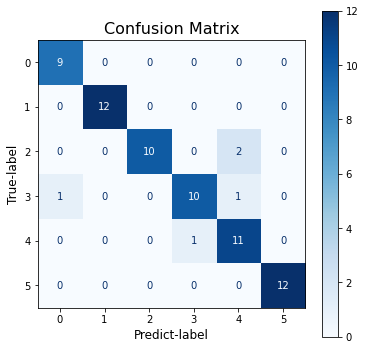

In [141]:
multi_cm(selector, X_train, y_train, y_train_pred)

In [142]:
class_report = classification_report(y_train, y_train_pred, target_names=train_classes)

print("-"*55)
print("Report for Model File: ")
print("-"*55)
print(class_report)
print("-"*55)

-------------------------------------------------------
Report for Model File: 
-------------------------------------------------------
              precision    recall  f1-score   support

     sitting       0.90      1.00      0.95         9
     cycling       1.00      1.00      1.00        12
     bending       1.00      0.83      0.91        12
     walking       0.91      0.83      0.87        12
       lying       0.79      0.92      0.85        12
    standing       1.00      1.00      1.00        12

    accuracy                           0.93        69
   macro avg       0.93      0.93      0.93        69
weighted avg       0.93      0.93      0.93        69

-------------------------------------------------------


#### - Training Data ROC Curve ( Raw Features )

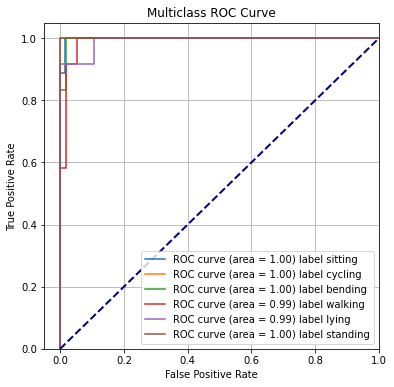

In [143]:
plot_roc (train_classes, y_train, y_train_score)

#### - Test Data Confusion Matrix ( Raw Features )

[[4 0 0 0 0 0]
 [0 3 0 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 2 1 0]
 [0 0 1 1 1 0]
 [0 0 0 0 0 3]]


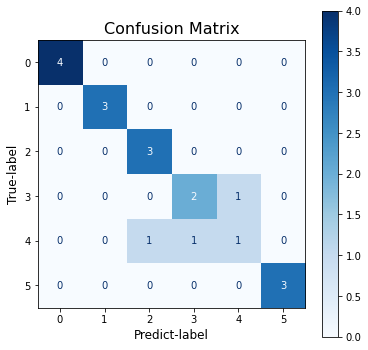

In [144]:
multi_cm(selector, X_test, y_test, y_test_pred)

In [145]:
class_report = classification_report(y_test, y_test_pred, target_names=train_classes)

print("-"*55)
print("Report for Model File: ")
print("-"*55)
print(class_report)
print("-"*55)

-------------------------------------------------------
Report for Model File: 
-------------------------------------------------------
              precision    recall  f1-score   support

     sitting       1.00      1.00      1.00         4
     cycling       1.00      1.00      1.00         3
     bending       0.75      1.00      0.86         3
     walking       0.67      0.67      0.67         3
       lying       0.50      0.33      0.40         3
    standing       1.00      1.00      1.00         3

    accuracy                           0.84        19
   macro avg       0.82      0.83      0.82        19
weighted avg       0.83      0.84      0.83        19

-------------------------------------------------------


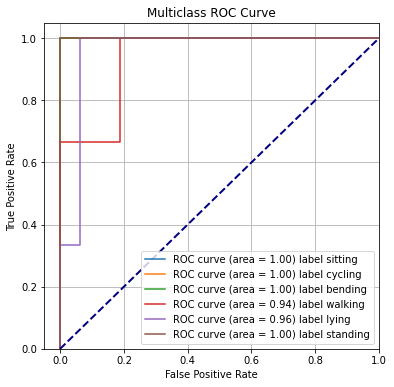

In [146]:
plot_roc (test_classes, y_test, y_test_score)

In [147]:
frames = [df_fii_GNB,df_fii_MNB]
df_ii_result = pd.concat(frames)
df_ii_result.index = ['GaussianNB', 'MultinomialNB']
df_ii_result

,l,mean_cv_score,train_accuracy,test_accuracy,test_error,alpha
GaussianNB,1.0,0.898901,0.971014,0.947368,0.052632,NaN
MultinomialNB,10.0,0.863231,0.927536,0.842105,0.157895,0.3


<Strong>Answer</Strong><br>

* Based on the highest cv scores, GaussianNB classifier performed slightly better. The test accuracy is also higher than multinomial classification method. 
* We can also see a trends of cv score in GaussianNB classifier as number of features increase the performance becomes poor, however Multinomail is kind of the opposite of this(in general). Therefore we can conclude that GaussainNB classifier works better with data which instance numbers more than feature numbers

### (f) iii. Which method is better for multi-class classification in this problem?

In [152]:
frames = [df_fi,df_fi_std, df_fii_GNB,df_fii_MNB]
df_iii_result = pd.concat(frames)
df_iii_result.index = ['L1logreg','L1logreg_std','GaussianNB', 'MultinominoalNB']
df_iii_result

,l,c,mean_cv_score,train_accuracy,test_accuracy,test_error,alpha
L1logreg,1.0,21.544347,0.912088,0.985507,0.894737,0.105263,NaN
L1logreg_std,1.0,21.544347,0.638462,0.855072,0.631579,0.368421,NaN
GaussianNB,1.0,NaN,0.898901,0.971014,0.947368,0.052632,NaN
MultinominoalNB,10.0,NaN,0.863231,0.927536,0.842105,0.157895,0.3


* Based on the mean cross validation result at the best l, the L1 penalized logistic regression classification method using raw features has the highest mean cv scores, The Gaussian Naive Bayer mean cv scores is slightly lower than it. We can conclude L1 penalized logistic regression classifier performs the best in time series data, but Gaussian Naive Bayer is also a good model. 
* However it is still hard to say which classifier is the best for multiclass classification, because Naive Bayes type classifier come with an assumption if there is no correlation between each feature. This assumption is sometimes is really dangerous to use, we need to be careful
* Based on the running time, both NB classifiers in general are faster than LogisticRegression classifier. Since L1-penalized LogisticRegression classifier takes time to select the best hyperparameter Cs among all C candidates.

# 2. ISLR 3.7.4

<strong>Answer</strong><br>
(a) For training, the cubic regression has a lower RSS, since cubic regression has a higher flexibility than linear regression model. <br>
(b) For testing, the linear regression model fits better, since the true relationship between X and Y is linear.<br>
(c) Cubic regression model will have a lower RSS, since cubic regression has a higher flexibility than linear regression model.<br>
(d) In general, cubic regression model has a higher flexibility and low bias, however it depends. For example, if the true relationship is linear then the same as (b), if it is highly non linear then cubic regression model is better.<br>

# 3. ISLR, 4.8.3

$$k\in \left \{ 1,2,3...k \right \}$$ <br>

$$f_{k}(x) = \frac{1}{\sqrt{2\pi}\sigma_{k}}exp({-\frac{1}{2\sigma_{k}^{2}}(x-\mu_{k})^{2})}$$ <br>

$$p_{k}(x) = \frac{\pi_{k}f_{k}}{\sum_{l=1}^{K}\pi_{l}\frac{1}{\sqrt{2\pi}\sigma_{k}}exp({-\frac{1}{2\sigma_{k}^{2}}(x-\mu_{k})^{2})}}$$<br>

$$p_{k}(x) = \frac{\pi_{k}\frac{1}{\sqrt{2\pi}\sigma_{k}}exp({-\frac{1}{2\sigma_{k}^{2}}(x-\mu_{k})^{2})}}{\sum_{l=1}^{K}\pi_{l}\frac{1}{\sqrt{2\pi}\sigma_{k}}exp({-\frac{1}{2\sigma_{k}^{2}}(x-\mu_{k})^{2})}}$$

$$Arg_{k}max(\delta_{k}) = Arg_{k}max(\pi_{k}\frac{1}{\sqrt{2\pi}\sigma_{k}}exp({-\frac{1}{2\sigma_{k}^{2}}(x-\mu_{k})^{2})})$$

$$Arg_{k}max(\delta_{k}) = Arg_{k}max(log(\pi_{k}\frac{1}{\sqrt{2\pi}\sigma_{k}}exp({-\frac{1}{2\sigma_{k}^{2}}(x-\mu_{k})^{2})}))$$

$$Arg_{k}max(\delta_{k}) = Arg_{k}max(log(\pi_{k})-log(\sqrt{2\pi}\sigma_{k}) -\frac{1}{2\sigma_{k}^{2}}(x-\mu_{k})^{2})$$

$$Arg_{k}max(\delta_{k}) = Arg_{k}max(log(\pi_{k})-log(\sqrt{2\pi}\sigma_{k}) -\frac{1}{2\sigma_{k}^{2}}(x^{2}-2\mu_{k}+\mu_{k})^{2})$$

$$Arg_{k}max(\delta_{k}) = Arg_{k}max(log(\pi_{k})-log(\sqrt{2\pi}\sigma_{k}) -\frac{x^{2}}{2\sigma_{k}^{2}}+\frac{\mu_{k}}{\sigma_{k}^{2}} - \frac{\mu_{k}^{2}}{2\sigma_{k}^{2}})$$

Since $log(\sqrt{2\pi}\sigma_{k})$ is constant
Therefore we can rewrite equation as: <br>
$$Arg_{k}max(\delta_{k}) = Arg_{k}max(log(\pi_{k})-\frac{x^{2}}{2\sigma_{k}^{2}}+\frac{\mu_{k}}{\sigma_{k}^{2}} - \frac{\mu_{k}^{2}}{2\sigma_{k}^{2}})$$
This equation is quaratic in x

# 4. ISLR 4.8.7

$$\pi_{yes}(x) = \frac{\pi_{yes}f_{yes}(x)}{\pi_{yes} f_{yes}(x)+\pi_{no}f_{no}(x)}$$

$\pi_{yes}$ = 80% = 0.8 <br>
$\pi_{no}$ = 1-80% = 0.2 <br>
$$f_{yes} = \frac{1}{\sqrt{2\pi\sigma^{2}}} exp(\frac{-(x-\mu_{yes})^{2}}{2\sigma^{2}})$$
$$f_{no} = \frac{1}{\sqrt{2\pi\sigma^{2}}} exp(\frac{-(x-\mu_{no})^{2}}{2\sigma^{2}})$$

X = 4<br>
$\sigma^{2} = 36$<br>
$\mu_{yes} = \bar{X}_{yes} = 10$ <br>
$\mu_{no} = \bar{X}_{no} = 0$<br>
We plug in these terms into the equation, the $\frac{1}{\sqrt{2\pi\sigma^{2}}}$ term canceled out <br>
$$\pi_{yes}(4) = \frac{0.8exp(-\frac{(4-10)^{2}}{2\times36})} {0.8exp(-\frac{(4-10)^{2}}{2\times36})+0.2exp(-\frac{(4-0)^{2}}{2\times36})}$$

$$\pi_{yes} = 0.752 $$